# Задача 6. Компьютерное зрение: задача сегментации

* **Дедлайн**: 11.04.2025, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [x] Сделать train/test split (или кросс-валидацию), зафиксировать все сиды чтобы более-менее воспроизводились результаты. Добавить метрику **jaccard index**. Переобучиться на одном батче (например 4 картинки), попробовать получить почти идеальное качество, посмотреть получилось или нет. Посчитать метрики для батча и для теста. Обучить на всем train, построить train/val кривые для loss и для **jaccard index**, подобрать оптимальное время обучения (количество шагов) для фиксированных параметров. Визуализировать topN самых плохих предсказаний.
- [x] Попробовать улучшить качество не меняя архитектуру: аугментации, гиперпараметры. Сделать test time аугментации через horizontal flip, посмотреть улучшается ли что-то.
- [x] Попробовать улучшить качество изменяя архитектуру.
- [x] * (**+2 балла**) Сделать train/test разбиение. Внутри train сделать 5fold, обучить 5 моделей. Построить кривые обучения для каждого фолда. Предсказать тест со всех 5 моделей и сагрегировать предсказания (до расчета метрик), сравнить с одной моделью обученной на всех данных. Сравнить с моделями обученными на фолдах. Сравнить плохие предсказания теста на разных фолдах. Ошибается на одних и тех же семплах или на разных?
- [ ] * (**+3 балла**) Сделать unet с pretrained энкодером (можно взять vgg или resnet18/34), сравнить с предыдущими пунктами.

In [2]:
import torch
import numpy as np
import torchvision.transforms as tr
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import torch.nn as nn

from sklearn.model_selection import train_test_split, KFold
from tqdm import tqdm
from torchvision import models

from IPython.display import clear_output

In [3]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

In [4]:
DEVICE = "cuda"

In [5]:
!rm -rf dataset dataset.zip
!gdown 11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe
!unzip dataset.zip
clear_output()

In [6]:
class FacesDataset(torch.utils.data.Dataset):
    def __init__(
            self, 
            images, 
            masks,
            resize_shape=(256, 256),
            transforms=None
    ):
        
        self.image_paths = images
        self.mask_paths = masks
        self.resize_shape = resize_shape
        self.transforms = transforms
    
    def __getitem__(self, i):
        
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2GRAY)

        mask[mask != 0] = 1
                
        image = cv2.resize(image, self.resize_shape)
        mask = cv2.resize(mask, self.resize_shape)
                
        if self.transforms:
            image, mask = self.transforms(image), self.transforms(mask)
                    
        return image, mask
        
    def __len__(self):
        return len(self.image_paths)

In [7]:
def visualize(data, titles):
    for chtoto in data:
        fig, axs = plt.subplots(nrows=1, ncols=len(titles), figsize=(12, 5))
        axs = axs.flatten()
        for i, image in enumerate(chtoto):
            ax = axs[i]
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.grid(False)
            ax.set_title(titles[i])
            ax.imshow(image)
        plt.show()

In [8]:
def get_images_list(images_dir):
    return [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]

In [9]:
def to_tensor(image, **kwargs):
    if len(image.shape) == 3:
        image = image / 255
        image = image.transpose(2, 0, 1)
    return image.astype("float32")

def get_transforms():
    return tr.Compose([to_tensor])

In [10]:
images = get_images_list("dataset/images")
masks = get_images_list("dataset/masks")

train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=RANDOM_SEED)

dataset = FacesDataset(images, masks)
train_dataset = FacesDataset(train_images, train_masks, transforms=get_transforms())
test_dataset = FacesDataset(test_images, test_masks, transforms=get_transforms())

print(f"Dataset length: {len(dataset)}")
print(f"Train length: {len(train_dataset)}")
print(f"Test length: {len(test_dataset)}")

Dataset length: 2000
Train length: 1600
Test length: 400


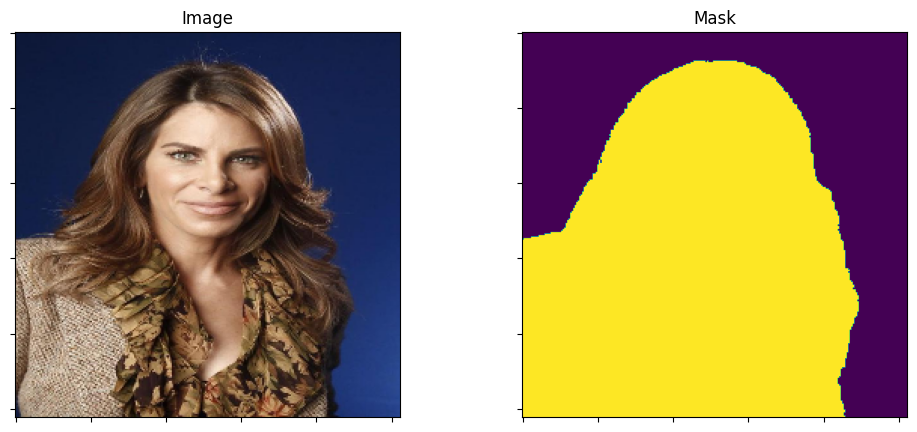

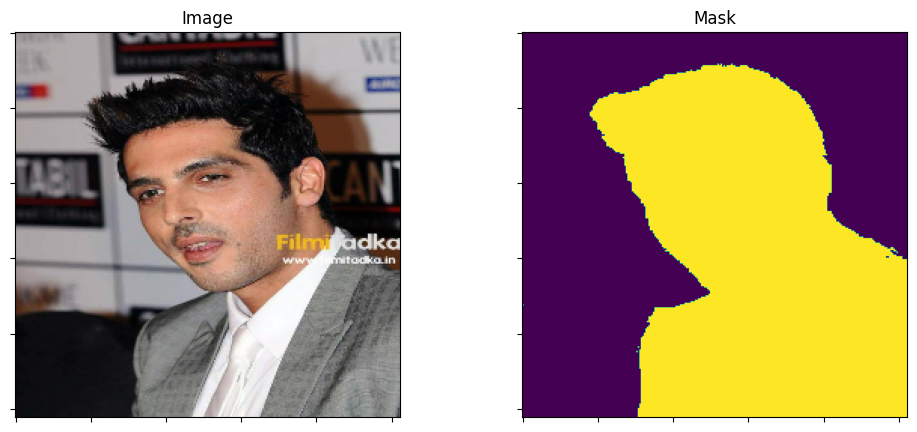

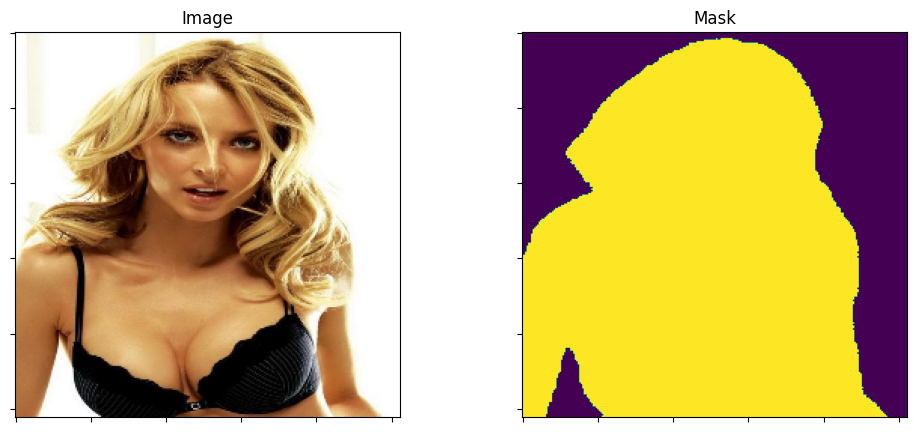

In [11]:
visualize([dataset[i] for i in range(3)], titles=["Image", "Mask"])

# UNet

In [12]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock, self).__init__()

        self.seq_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                                       nn.BatchNorm2d(out_channels),
                                       nn.ReLU(inplace=True))

    def forward(self, x):
        return self.seq_block(x)

class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
          super(CNNBlocks, self).__init__()

          self.layers = nn.ModuleList()
          for i in range(n_conv):
              self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
              in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                                nn.MaxPool2d(2, 2)]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                            CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding)]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x

In [13]:
class UNet(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNet, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down), # downscaled (so increase n maps 2x n_down times)
                               first_out_channels * (2 ** (n_down - 1)), # we have 2x channels here, because need to concat
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

In [14]:
EPOCHS = 30
BATCH_SIZE = 32

In [15]:
def iou_score(output, target):
    output = (torch.sigmoid(output) >= 0.5).float()
        
    intersection = (output * target).sum()
    union = output.sum() + target.sum() - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()

In [16]:
def train(model, optimizer, loss_fn, train_loader, test_loader):
    model = model.to(DEVICE)
    
    history = {
        "train_loss": [],
        "train_iou": [],
        "test_loss": [],
        "test_iou": []
    }
    
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        train_iou = 0.0
        
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} (Train)"):
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs).squeeze()
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            
            batch_size = inputs.size(0)
            train_loss += loss.item() * batch_size
            train_iou += iou_score(outputs, targets) * batch_size
        
        train_loss /= len(train_loader.dataset)
        train_iou /= len(train_loader.dataset)
        history["train_loss"].append(train_loss)
        history["train_iou"].append(train_iou)
        
        model.eval()
        test_loss = 0.0
        test_iou = 0.0
        
        with torch.no_grad():
            for inputs, targets in tqdm(test_loader, desc=f"Epoch {epoch+1}/{EPOCHS} (Test)"):
                inputs = inputs.to(DEVICE)
                targets = targets.to(DEVICE)
                
                outputs = model(inputs).squeeze()
                loss = loss_fn(outputs, targets)
                
                batch_size = inputs.size(0)
                test_loss += loss.item() * batch_size
                test_iou += iou_score(outputs, targets) * batch_size
        
        test_loss /= len(test_loader.dataset)
        test_iou /= len(test_loader.dataset)
        history["test_loss"].append(test_loss)
        history["test_iou"].append(test_iou)
        
        print(f"Epoch {epoch+1}: "
              f"Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f} | "
              f"Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}")
    
    return history

In [17]:
def plot_history(history):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 9))
    axs = axs.flatten()

    axs[0].set_title("Losses")
    axs[0].plot(range(1, EPOCHS + 1), history["train_loss"], marker="D", label="Train Loss")
    axs[0].plot(range(1, EPOCHS + 1), history["test_loss"], marker="D", label="Test Loss")
    axs[0].legend()

    axs[1].set_title("IoU")
    axs[1].plot(range(1, EPOCHS + 1), history["train_iou"], marker="D", label="Train IoU")
    axs[1].plot(range(1, EPOCHS + 1), history["test_iou"], marker="D", label="Test IoU")
    axs[1].legend()

    plt.show()

In [18]:
def visualizeTopNWorst(model, test_dataset, n):
    model.eval()
    ious = []
    for i, (image, mask) in enumerate(test_dataset):
        with torch.no_grad():
            pred = model(torch.from_numpy(image).to(DEVICE).unsqueeze(0)).squeeze()
            iou = iou_score(pred, torch.from_numpy(mask).to(DEVICE))
            ious.extend([(iou, i)])
    ious = sorted(ious, key=lambda x: x[0])[:n]
    data = []
    for _, i in ious:
        image, mask = test_dataset[i]
        with torch.no_grad():
            pred = model(torch.from_numpy(image).to(DEVICE).unsqueeze(0)).squeeze()
        pred = (torch.sigmoid(pred) >= 0.5).float()
        data.append((image.transpose(1, 2, 0), pred.cpu().numpy(), mask))
    visualize(data, titles=["Image", "Prediction", "Mask"])

In [19]:
def visualizeTopNBest(model, test_dataset, n):
    model.eval()
    ious = []
    for i, (image, mask) in enumerate(test_dataset):
        with torch.no_grad():
            pred = model(torch.from_numpy(image).to(DEVICE).unsqueeze(0)).squeeze()
            iou = iou_score(pred, torch.from_numpy(mask).to(DEVICE))
            ious.extend([(iou, i)])
    ious = sorted(ious, key=lambda x: x[0], reverse=True)[:n]
    data = []
    for _, i in ious:
        image, mask = test_dataset[i]
        with torch.no_grad():
            pred = model(torch.from_numpy(image).to(DEVICE).unsqueeze(0)).squeeze()
        pred = (torch.sigmoid(pred) >= 0.5).float()
        data.append((image.transpose(1, 2, 0), pred.cpu().numpy(), mask))
    visualize(data, titles=["Image", "Prediction", "Mask"])

# Переобучение на одном батче размера 4

In [19]:
model = UNet(3, 16, 1)
loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters())

train_loader = torch.utils.data.DataLoader(torch.utils.data.Subset(train_dataset, range(4)), batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset ,batch_size=BATCH_SIZE)

In [20]:
history = train(model, optim, loss_fn, train_loader, test_loader)

Epoch 1/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


Epoch 1: Train Loss: 0.7205, Train IoU: 0.2692 | Test Loss: 0.6935, Test IoU: 0.0000


Epoch 2/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.03it/s]


Epoch 2: Train Loss: 0.6648, Train IoU: 0.4285 | Test Loss: 0.6936, Test IoU: 0.0000


Epoch 3/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.04it/s]


Epoch 3: Train Loss: 0.6268, Train IoU: 0.5264 | Test Loss: 0.6938, Test IoU: 0.0000


Epoch 4/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.06it/s]


Epoch 4: Train Loss: 0.5893, Train IoU: 0.6138 | Test Loss: 0.6939, Test IoU: 0.0000


Epoch 5/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


Epoch 5: Train Loss: 0.5515, Train IoU: 0.6919 | Test Loss: 0.6940, Test IoU: 0.0000


Epoch 6/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


Epoch 6: Train Loss: 0.5104, Train IoU: 0.7669 | Test Loss: 0.6938, Test IoU: 0.0000


Epoch 7/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.00it/s]


Epoch 7: Train Loss: 0.4716, Train IoU: 0.8261 | Test Loss: 0.6932, Test IoU: 0.0000


Epoch 8/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.03it/s]


Epoch 8: Train Loss: 0.4359, Train IoU: 0.8792 | Test Loss: 0.6921, Test IoU: 0.0111


Epoch 9/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 9: Train Loss: 0.4101, Train IoU: 0.9268 | Test Loss: 0.6903, Test IoU: 0.1881


Epoch 10/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


Epoch 10: Train Loss: 0.3924, Train IoU: 0.9489 | Test Loss: 0.6879, Test IoU: 0.3112


Epoch 11/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.03it/s]


Epoch 11: Train Loss: 0.3790, Train IoU: 0.9579 | Test Loss: 0.6850, Test IoU: 0.3888


Epoch 12/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 12: Train Loss: 0.3701, Train IoU: 0.9510 | Test Loss: 0.6814, Test IoU: 0.4339


Epoch 13/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


Epoch 13: Train Loss: 0.3645, Train IoU: 0.9474 | Test Loss: 0.6792, Test IoU: 0.5011


Epoch 14/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch 14: Train Loss: 0.3546, Train IoU: 0.9589 | Test Loss: 0.6779, Test IoU: 0.5456


Epoch 15/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 15: Train Loss: 0.3491, Train IoU: 0.9610 | Test Loss: 0.6767, Test IoU: 0.5377


Epoch 16/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 16: Train Loss: 0.3414, Train IoU: 0.9670 | Test Loss: 0.6740, Test IoU: 0.5436


Epoch 17/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 17: Train Loss: 0.3335, Train IoU: 0.9743 | Test Loss: 0.6712, Test IoU: 0.5488


Epoch 18/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch 18: Train Loss: 0.3281, Train IoU: 0.9748 | Test Loss: 0.6735, Test IoU: 0.5368


Epoch 19/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.14it/s]


Epoch 19: Train Loss: 0.3228, Train IoU: 0.9754 | Test Loss: 0.6796, Test IoU: 0.5278


Epoch 20/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.12it/s]


Epoch 20: Train Loss: 0.3181, Train IoU: 0.9770 | Test Loss: 0.6884, Test IoU: 0.5236


Epoch 21/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


Epoch 21: Train Loss: 0.3133, Train IoU: 0.9788 | Test Loss: 0.6955, Test IoU: 0.5235


Epoch 22/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 22: Train Loss: 0.3093, Train IoU: 0.9804 | Test Loss: 0.7019, Test IoU: 0.5245


Epoch 23/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Epoch 23: Train Loss: 0.3057, Train IoU: 0.9813 | Test Loss: 0.7072, Test IoU: 0.5262


Epoch 24/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 24: Train Loss: 0.3017, Train IoU: 0.9830 | Test Loss: 0.7124, Test IoU: 0.5280


Epoch 25/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 25: Train Loss: 0.2976, Train IoU: 0.9853 | Test Loss: 0.7179, Test IoU: 0.5278


Epoch 26/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 26: Train Loss: 0.2938, Train IoU: 0.9870 | Test Loss: 0.7180, Test IoU: 0.5306


Epoch 27/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 27: Train Loss: 0.2906, Train IoU: 0.9873 | Test Loss: 0.7081, Test IoU: 0.5380


Epoch 28/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


Epoch 28: Train Loss: 0.2873, Train IoU: 0.9871 | Test Loss: 0.6942, Test IoU: 0.5447


Epoch 29/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 29: Train Loss: 0.2841, Train IoU: 0.9873 | Test Loss: 0.6861, Test IoU: 0.5473


Epoch 30/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.22it/s]

Epoch 30: Train Loss: 0.2809, Train IoU: 0.9889 | Test Loss: 0.6848, Test IoU: 0.5472


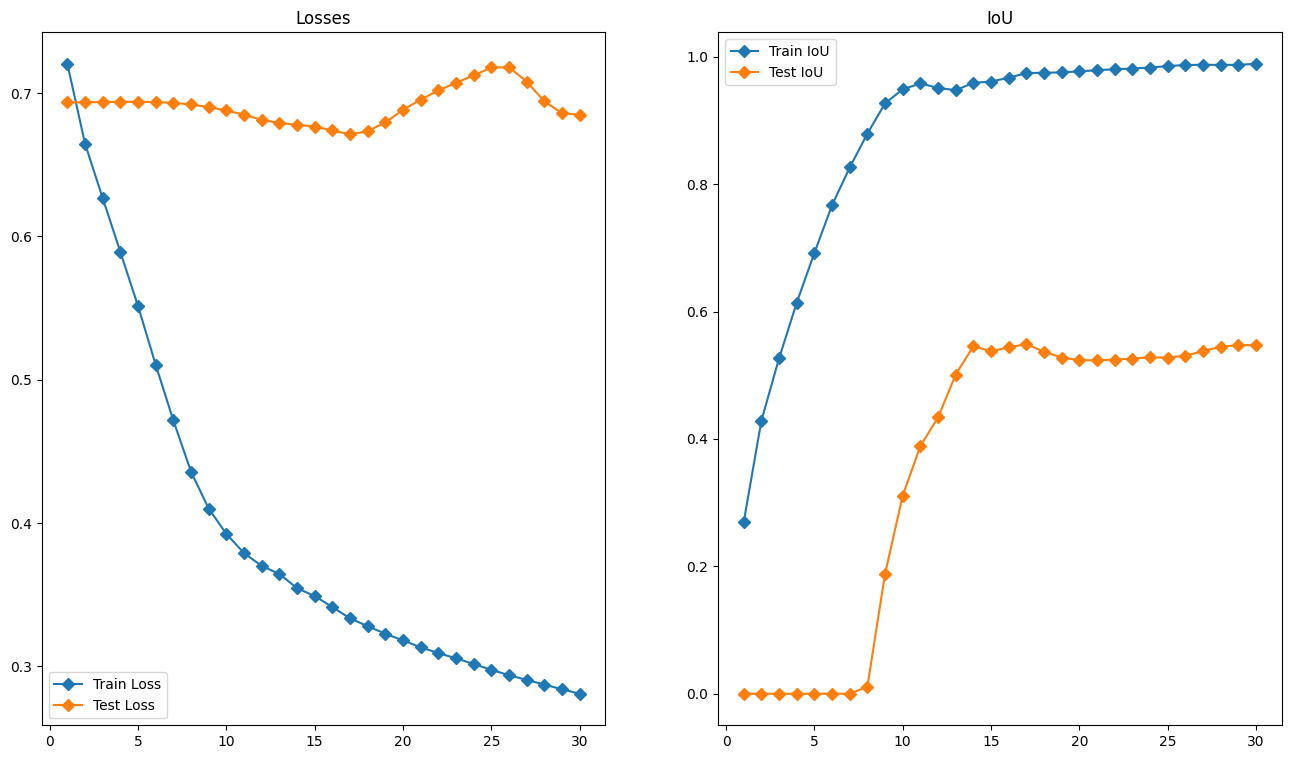

In [21]:
plot_history(history)

Как видно, переобучение на лицо

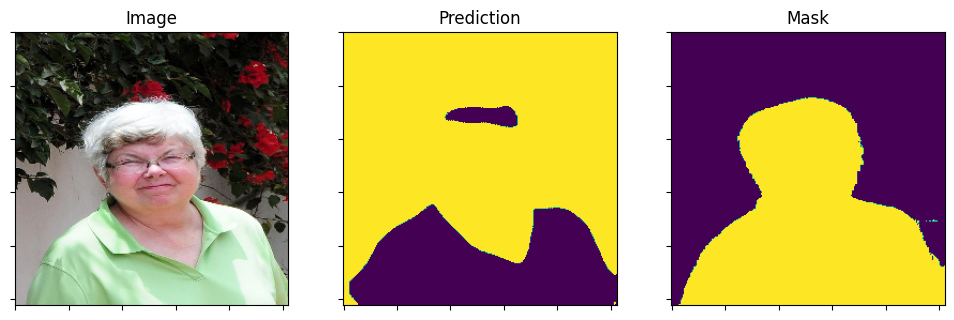

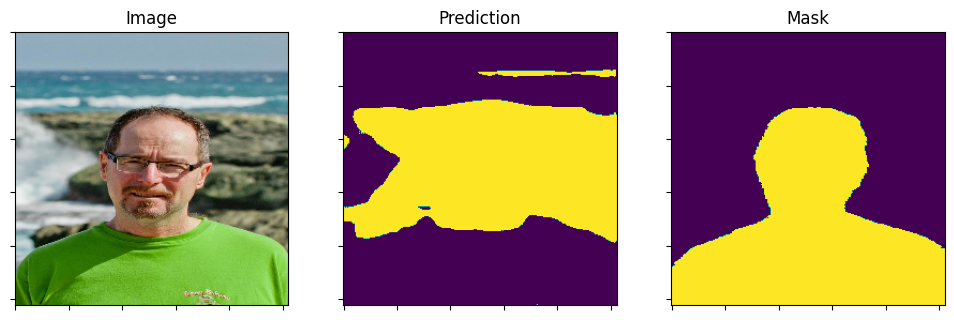

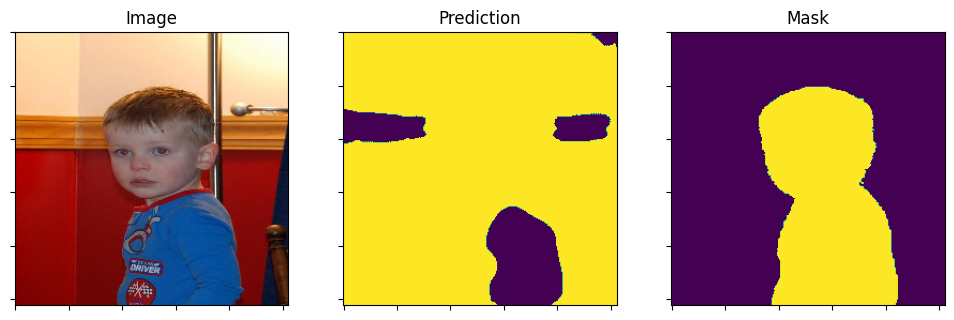

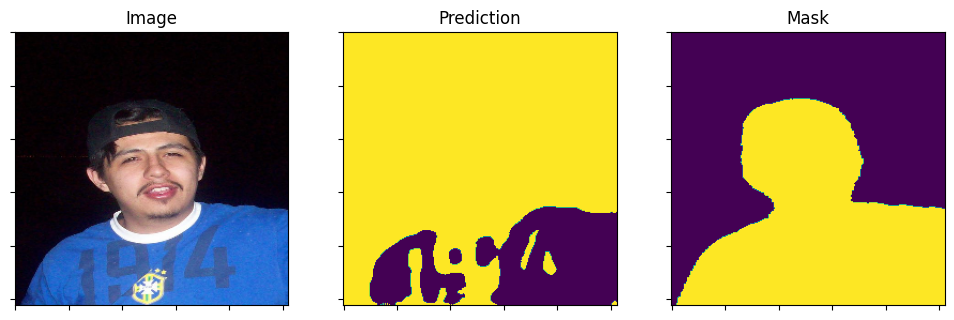

In [22]:
visualizeTopNWorst(model, test_dataset, 4)

Теперь обучим на нормальном тренировочном датасете

In [23]:
model = UNet(3, 16, 1)
loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset ,batch_size=BATCH_SIZE)

In [24]:
history = train(model, optim, loss_fn, train_loader, test_loader)

Epoch 1/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 1: Train Loss: 0.4402, Train IoU: 0.7327 | Test Loss: 0.3132, Test IoU: 0.8101


Epoch 2/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 2: Train Loss: 0.2543, Train IoU: 0.8656 | Test Loss: 0.2246, Test IoU: 0.8710


Epoch 3/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


Epoch 3: Train Loss: 0.1823, Train IoU: 0.8990 | Test Loss: 0.1651, Test IoU: 0.9024


Epoch 4/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 4: Train Loss: 0.1411, Train IoU: 0.9185 | Test Loss: 0.1505, Test IoU: 0.9075


Epoch 5/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 5: Train Loss: 0.1129, Train IoU: 0.9330 | Test Loss: 0.1318, Test IoU: 0.9139


Epoch 6/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 6: Train Loss: 0.0962, Train IoU: 0.9407 | Test Loss: 0.1218, Test IoU: 0.9157


Epoch 7/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


Epoch 7: Train Loss: 0.0867, Train IoU: 0.9449 | Test Loss: 0.0967, Test IoU: 0.9365


Epoch 8/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 8: Train Loss: 0.0763, Train IoU: 0.9508 | Test Loss: 0.0934, Test IoU: 0.9375


Epoch 9/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.31it/s]


Epoch 9: Train Loss: 0.0690, Train IoU: 0.9550 | Test Loss: 0.1182, Test IoU: 0.9201


Epoch 10/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 10: Train Loss: 0.0612, Train IoU: 0.9597 | Test Loss: 0.0843, Test IoU: 0.9442


Epoch 11/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 11: Train Loss: 0.0507, Train IoU: 0.9670 | Test Loss: 0.0785, Test IoU: 0.9481


Epoch 12/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.15it/s]


Epoch 12: Train Loss: 0.0464, Train IoU: 0.9692 | Test Loss: 0.0834, Test IoU: 0.9466


Epoch 13/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Epoch 13: Train Loss: 0.0408, Train IoU: 0.9733 | Test Loss: 0.0773, Test IoU: 0.9518


Epoch 14/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


Epoch 14: Train Loss: 0.0388, Train IoU: 0.9738 | Test Loss: 0.0850, Test IoU: 0.9466


Epoch 15/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 15: Train Loss: 0.0422, Train IoU: 0.9712 | Test Loss: 0.0750, Test IoU: 0.9502


Epoch 16/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 16: Train Loss: 0.0384, Train IoU: 0.9734 | Test Loss: 0.0725, Test IoU: 0.9529


Epoch 17/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


Epoch 17: Train Loss: 0.0373, Train IoU: 0.9744 | Test Loss: 0.0749, Test IoU: 0.9538


Epoch 18/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.33it/s]


Epoch 18: Train Loss: 0.0347, Train IoU: 0.9757 | Test Loss: 0.0794, Test IoU: 0.9526


Epoch 19/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 19: Train Loss: 0.0312, Train IoU: 0.9784 | Test Loss: 0.0841, Test IoU: 0.9514


Epoch 20/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.30it/s]


Epoch 20: Train Loss: 0.0312, Train IoU: 0.9780 | Test Loss: 0.0706, Test IoU: 0.9570


Epoch 21/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Epoch 21: Train Loss: 0.0277, Train IoU: 0.9805 | Test Loss: 0.0685, Test IoU: 0.9577


Epoch 22/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 22: Train Loss: 0.0298, Train IoU: 0.9790 | Test Loss: 0.0678, Test IoU: 0.9587


Epoch 23/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 23: Train Loss: 0.0246, Train IoU: 0.9825 | Test Loss: 0.0642, Test IoU: 0.9633


Epoch 24/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


Epoch 24: Train Loss: 0.0213, Train IoU: 0.9849 | Test Loss: 0.0598, Test IoU: 0.9643


Epoch 25/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 25: Train Loss: 0.0206, Train IoU: 0.9851 | Test Loss: 0.0640, Test IoU: 0.9634


Epoch 26/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 26: Train Loss: 0.0194, Train IoU: 0.9860 | Test Loss: 0.0632, Test IoU: 0.9640


Epoch 27/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


Epoch 27: Train Loss: 0.0186, Train IoU: 0.9865 | Test Loss: 0.0585, Test IoU: 0.9656


Epoch 28/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 28: Train Loss: 0.0175, Train IoU: 0.9872 | Test Loss: 0.0616, Test IoU: 0.9650


Epoch 29/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 29: Train Loss: 0.0172, Train IoU: 0.9873 | Test Loss: 0.0606, Test IoU: 0.9656


Epoch 30/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.22it/s]

Epoch 30: Train Loss: 0.0162, Train IoU: 0.9880 | Test Loss: 0.0668, Test IoU: 0.9634


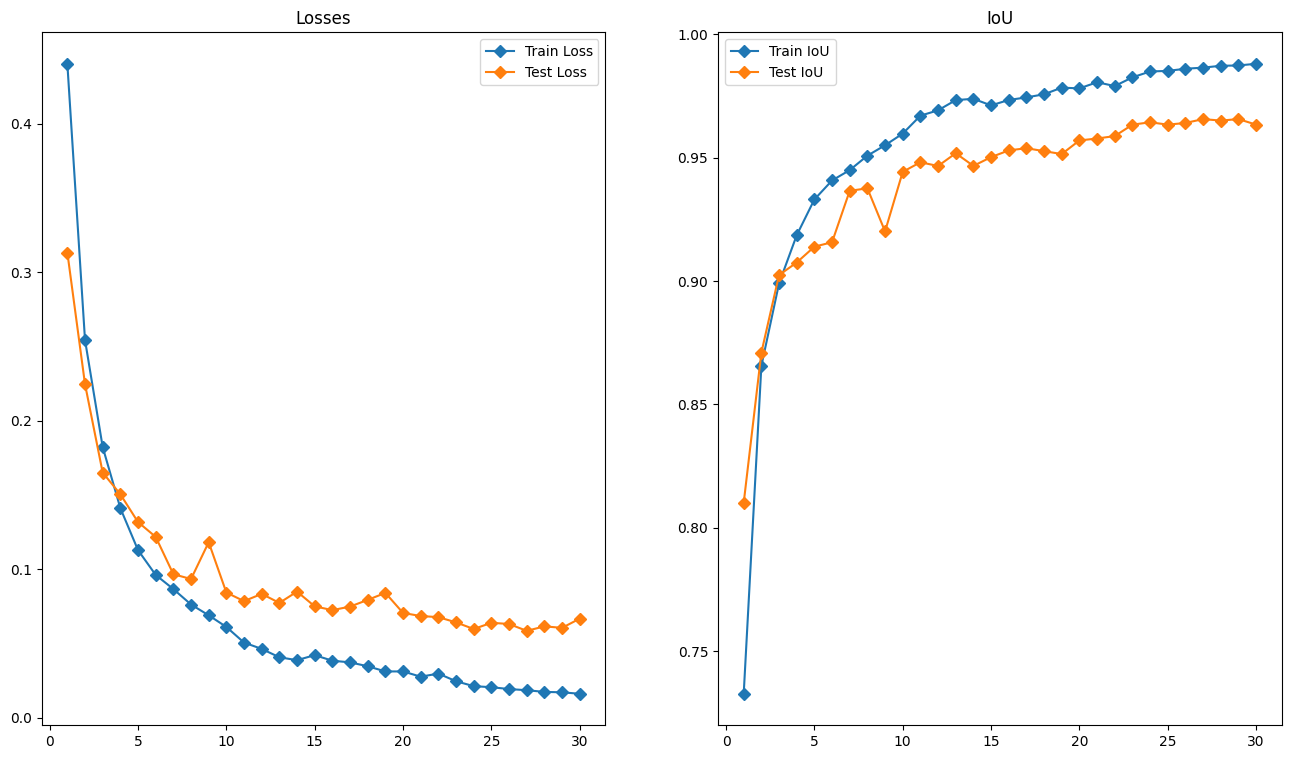

In [25]:
plot_history(history)

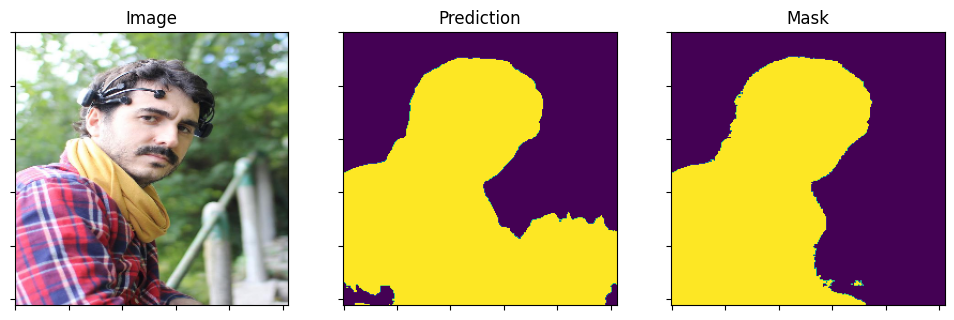

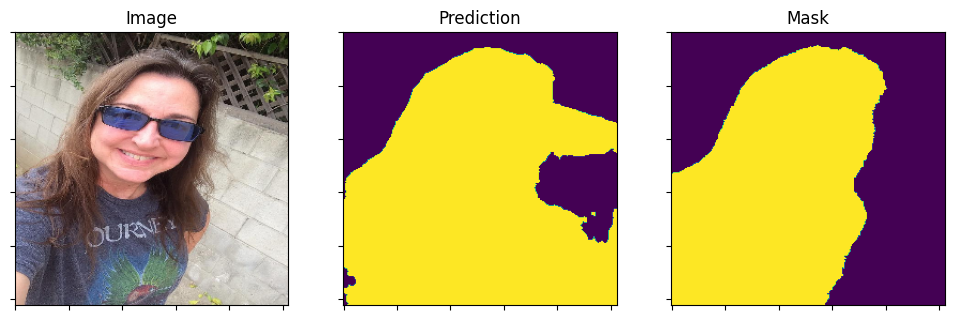

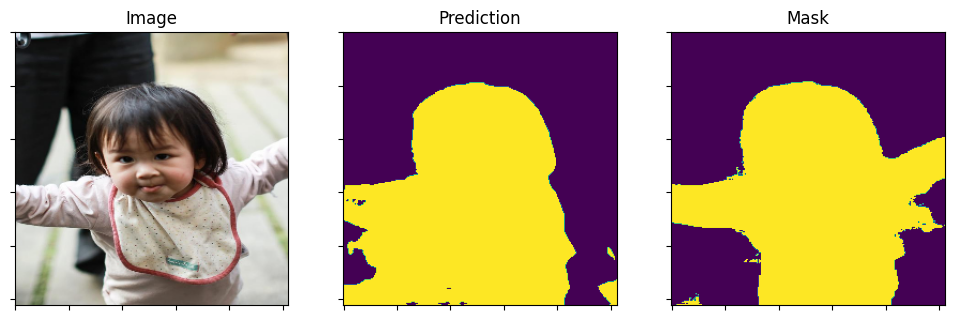

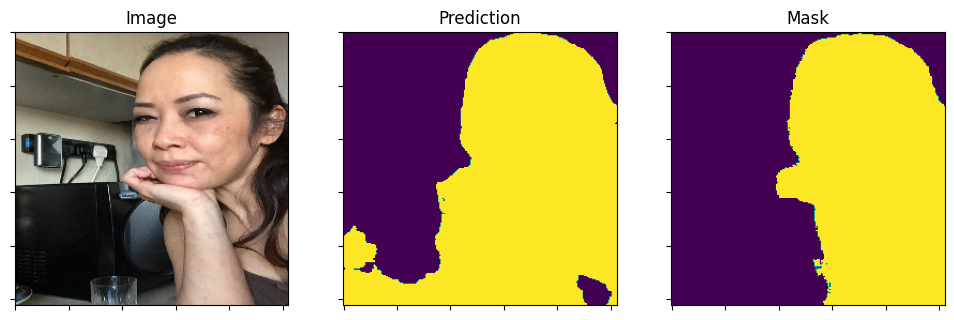

In [26]:
visualizeTopNWorst(model, test_dataset, 4)

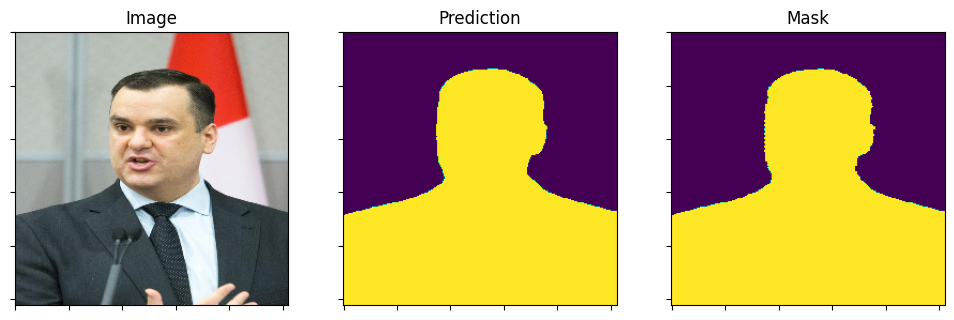

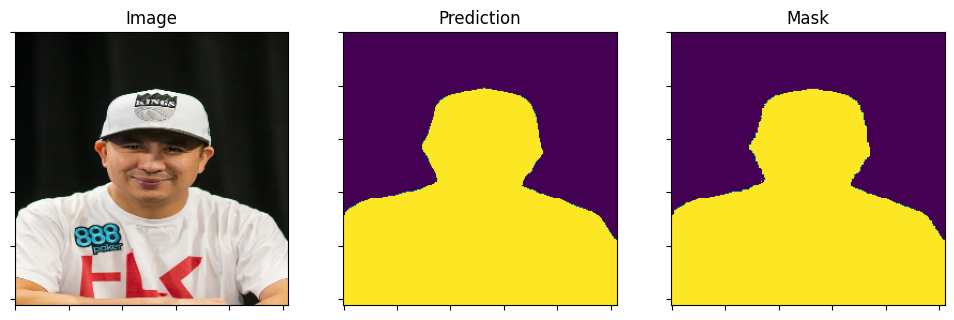

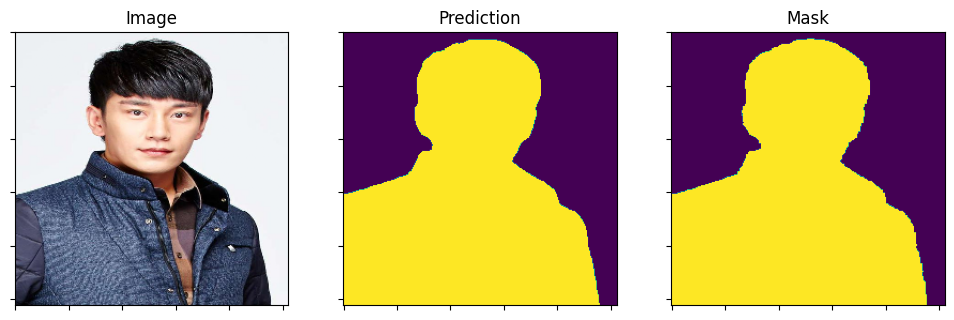

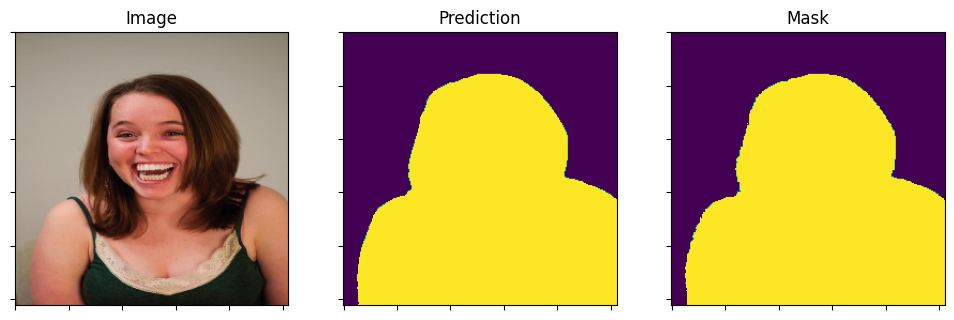

In [27]:
visualizeTopNBest(model, test_dataset, 4)

# Аугментация

In [28]:
def get_augmentation_transforms():
    return tr.Compose([
        tr.ToPILImage(),
        tr.RandomHorizontalFlip(p=1.0),
        np.asarray,
        to_tensor,
    ])

In [29]:
model = UNet(3, 16, 1)
loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters())

augmented_train_dataset = FacesDataset(train_images, train_masks, transforms=get_augmentation_transforms())
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.ConcatDataset([train_dataset, augmented_train_dataset]), 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [30]:
history = train(model, optim, loss_fn, train_loader, test_loader)

Epoch 1/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 1: Train Loss: 0.4344, Train IoU: 0.7075 | Test Loss: 0.3212, Test IoU: 0.8436


Epoch 2/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.22it/s]


Epoch 2: Train Loss: 0.2358, Train IoU: 0.8740 | Test Loss: 0.1741, Test IoU: 0.9105


Epoch 3/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 3: Train Loss: 0.1485, Train IoU: 0.9196 | Test Loss: 0.1321, Test IoU: 0.9235


Epoch 4/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


Epoch 4: Train Loss: 0.1095, Train IoU: 0.9367 | Test Loss: 0.1099, Test IoU: 0.9310


Epoch 5/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  2.89it/s]


Epoch 5: Train Loss: 0.0886, Train IoU: 0.9461 | Test Loss: 0.1014, Test IoU: 0.9353


Epoch 6/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 6: Train Loss: 0.0734, Train IoU: 0.9542 | Test Loss: 0.0844, Test IoU: 0.9474


Epoch 7/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


Epoch 7: Train Loss: 0.0645, Train IoU: 0.9584 | Test Loss: 0.0802, Test IoU: 0.9484


Epoch 8/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.32it/s]


Epoch 8: Train Loss: 0.0545, Train IoU: 0.9641 | Test Loss: 0.0765, Test IoU: 0.9481


Epoch 9/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.34it/s]


Epoch 9: Train Loss: 0.0463, Train IoU: 0.9694 | Test Loss: 0.0794, Test IoU: 0.9491


Epoch 10/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


Epoch 10: Train Loss: 0.0451, Train IoU: 0.9695 | Test Loss: 0.0618, Test IoU: 0.9592


Epoch 11/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.30it/s]


Epoch 11: Train Loss: 0.0388, Train IoU: 0.9736 | Test Loss: 0.0603, Test IoU: 0.9606


Epoch 12/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


Epoch 12: Train Loss: 0.0393, Train IoU: 0.9729 | Test Loss: 0.0632, Test IoU: 0.9584


Epoch 13/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.08it/s]


Epoch 13: Train Loss: 0.0358, Train IoU: 0.9753 | Test Loss: 0.0567, Test IoU: 0.9629


Epoch 14/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 14: Train Loss: 0.0307, Train IoU: 0.9786 | Test Loss: 0.0539, Test IoU: 0.9655


Epoch 15/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.32it/s]


Epoch 15: Train Loss: 0.0264, Train IoU: 0.9814 | Test Loss: 0.0587, Test IoU: 0.9638


Epoch 16/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


Epoch 16: Train Loss: 0.0258, Train IoU: 0.9818 | Test Loss: 0.0589, Test IoU: 0.9629


Epoch 17/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 17: Train Loss: 0.0263, Train IoU: 0.9812 | Test Loss: 0.0624, Test IoU: 0.9619


Epoch 18/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 18: Train Loss: 0.0241, Train IoU: 0.9827 | Test Loss: 0.0514, Test IoU: 0.9675


Epoch 19/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.18it/s]


Epoch 19: Train Loss: 0.0205, Train IoU: 0.9851 | Test Loss: 0.0531, Test IoU: 0.9682


Epoch 20/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 20: Train Loss: 0.0194, Train IoU: 0.9858 | Test Loss: 0.0542, Test IoU: 0.9677


Epoch 21/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.05it/s]


Epoch 21: Train Loss: 0.0202, Train IoU: 0.9852 | Test Loss: 0.0583, Test IoU: 0.9650


Epoch 22/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 22: Train Loss: 0.0249, Train IoU: 0.9817 | Test Loss: 0.0597, Test IoU: 0.9642


Epoch 23/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 23: Train Loss: 0.0238, Train IoU: 0.9825 | Test Loss: 0.0541, Test IoU: 0.9657


Epoch 24/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


Epoch 24: Train Loss: 0.0223, Train IoU: 0.9834 | Test Loss: 0.0614, Test IoU: 0.9639


Epoch 25/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.20it/s]


Epoch 25: Train Loss: 0.0192, Train IoU: 0.9856 | Test Loss: 0.0587, Test IoU: 0.9680


Epoch 26/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


Epoch 26: Train Loss: 0.0164, Train IoU: 0.9875 | Test Loss: 0.0547, Test IoU: 0.9702


Epoch 27/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


Epoch 27: Train Loss: 0.0173, Train IoU: 0.9869 | Test Loss: 0.0550, Test IoU: 0.9682


Epoch 28/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.30it/s]


Epoch 28: Train Loss: 0.0161, Train IoU: 0.9877 | Test Loss: 0.0524, Test IoU: 0.9697


Epoch 29/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.31it/s]


Epoch 29: Train Loss: 0.0153, Train IoU: 0.9882 | Test Loss: 0.0524, Test IoU: 0.9702


Epoch 30/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.23it/s]

Epoch 30: Train Loss: 0.0145, Train IoU: 0.9887 | Test Loss: 0.0533, Test IoU: 0.9712


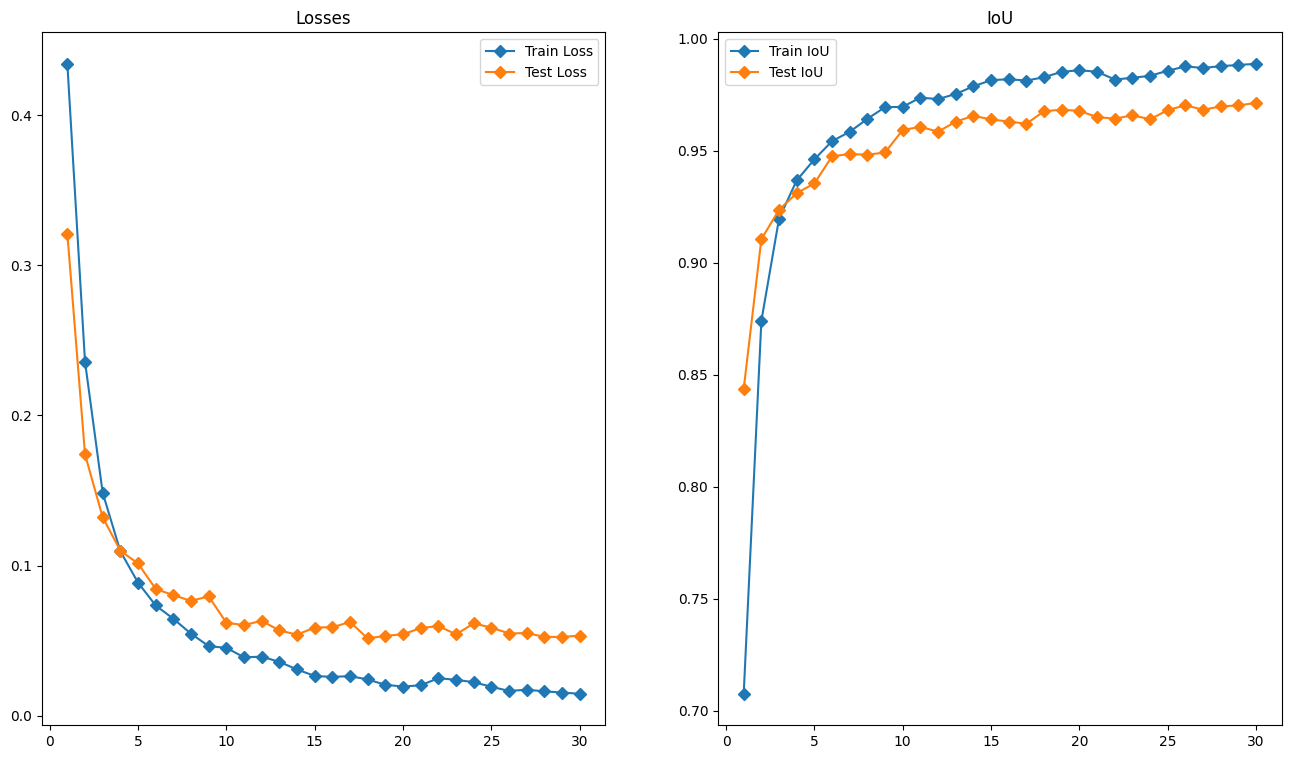

In [31]:
plot_history(history)

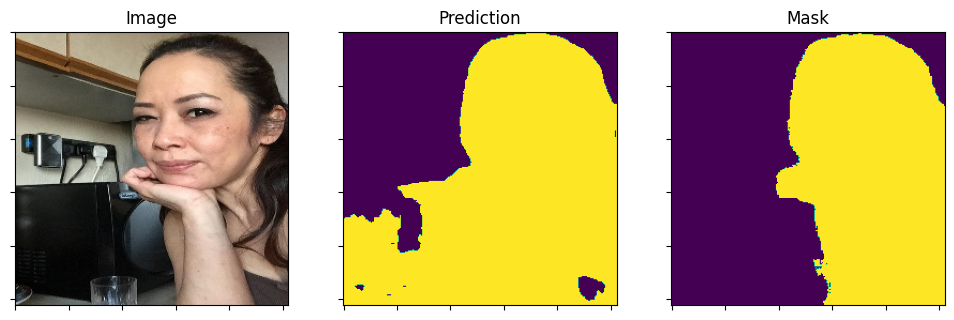

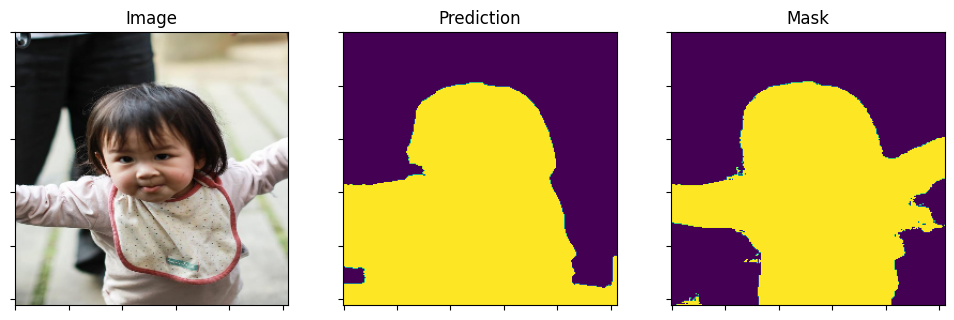

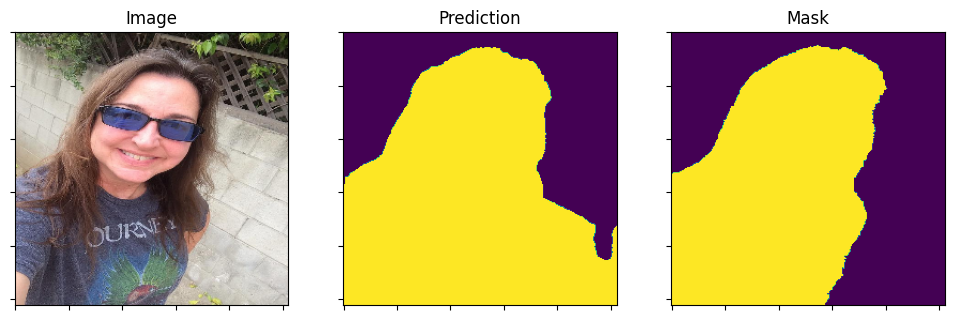

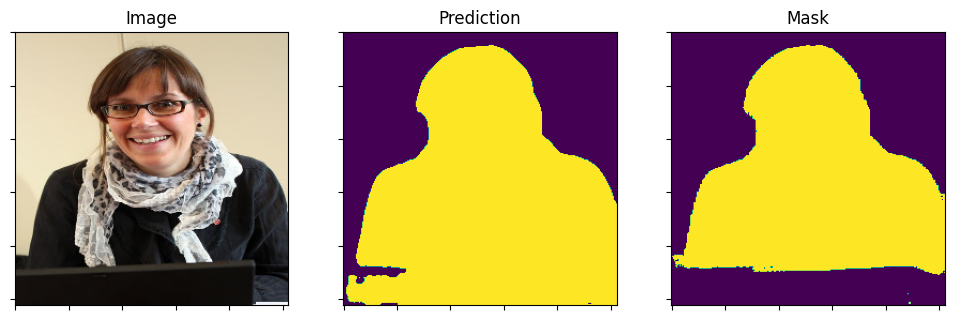

In [32]:
visualizeTopNWorst(model, test_dataset, 4)

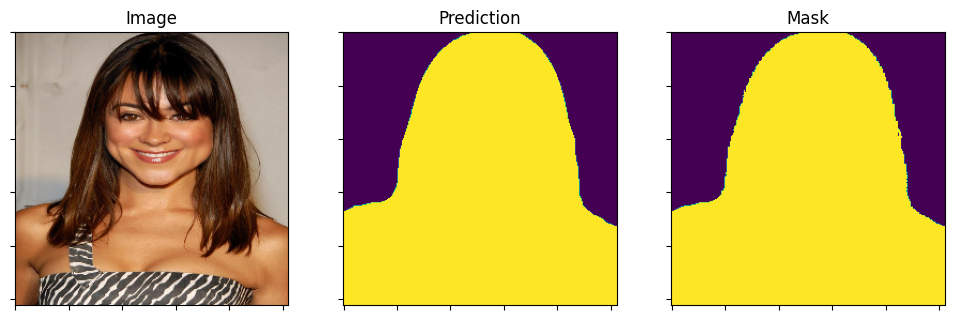

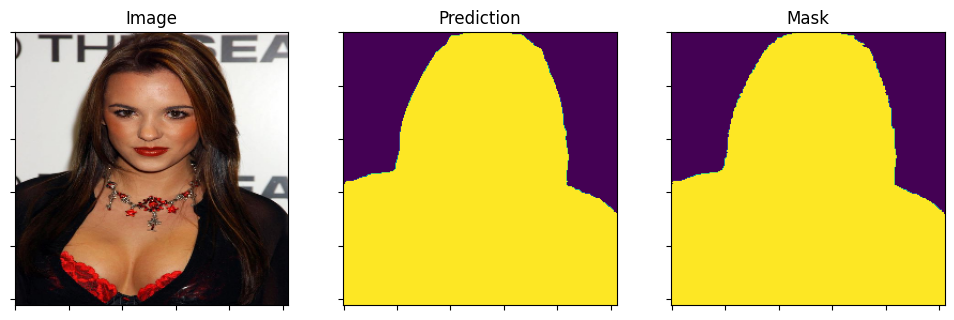

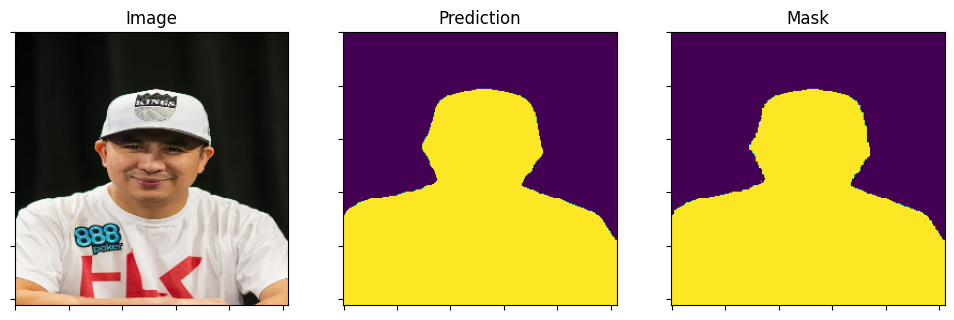

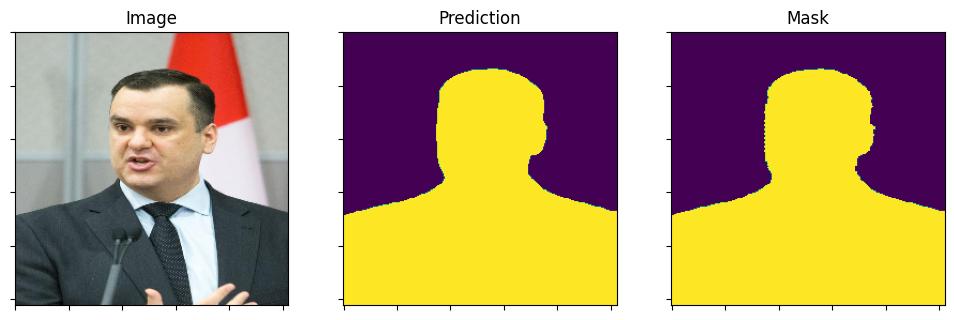

In [33]:
visualizeTopNBest(model, test_dataset, 4)

## Эксперименты

Посмотрим что будет, если изменить количество downsample'ов с 4 до, например, 2.

In [29]:
model = UNet(3, 16, 1, n_down=2)
loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model.parameters())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [30]:
history = train(model, optim, loss_fn, train_loader, test_loader)

Epoch 1/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.53it/s]


Epoch 1: Train Loss: 0.5501, Train IoU: 0.5973 | Test Loss: 0.6266, Test IoU: 0.5638


Epoch 2/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]


Epoch 2: Train Loss: 0.4660, Train IoU: 0.6601 | Test Loss: 0.4490, Test IoU: 0.6820


Epoch 3/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.55it/s]


Epoch 3: Train Loss: 0.4269, Train IoU: 0.6884 | Test Loss: 0.4900, Test IoU: 0.6941


Epoch 4/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.59it/s]


Epoch 4: Train Loss: 0.4052, Train IoU: 0.7023 | Test Loss: 0.7186, Test IoU: 0.6498


Epoch 5/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.56it/s]


Epoch 5: Train Loss: 0.3842, Train IoU: 0.7193 | Test Loss: 0.5244, Test IoU: 0.6793


Epoch 6/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.60it/s]


Epoch 6: Train Loss: 0.3672, Train IoU: 0.7317 | Test Loss: 0.5829, Test IoU: 0.6756


Epoch 7/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.57it/s]


Epoch 7: Train Loss: 0.3538, Train IoU: 0.7414 | Test Loss: 0.5844, Test IoU: 0.6800


Epoch 8/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.56it/s]


Epoch 8: Train Loss: 0.3470, Train IoU: 0.7466 | Test Loss: 0.4558, Test IoU: 0.7160


Epoch 9/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.55it/s]


Epoch 9: Train Loss: 0.3331, Train IoU: 0.7569 | Test Loss: 0.4061, Test IoU: 0.7321


Epoch 10/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.56it/s]


Epoch 10: Train Loss: 0.3257, Train IoU: 0.7615 | Test Loss: 0.3874, Test IoU: 0.7444


Epoch 11/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.60it/s]


Epoch 11: Train Loss: 0.3167, Train IoU: 0.7671 | Test Loss: 0.4536, Test IoU: 0.7281


Epoch 12/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.53it/s]


Epoch 12: Train Loss: 0.3127, Train IoU: 0.7716 | Test Loss: 0.3887, Test IoU: 0.7479


Epoch 13/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.55it/s]


Epoch 13: Train Loss: 0.3074, Train IoU: 0.7753 | Test Loss: 0.4034, Test IoU: 0.7491


Epoch 14/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.57it/s]


Epoch 14: Train Loss: 0.2989, Train IoU: 0.7808 | Test Loss: 0.3606, Test IoU: 0.7655


Epoch 15/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.56it/s]


Epoch 15: Train Loss: 0.2937, Train IoU: 0.7853 | Test Loss: 0.3683, Test IoU: 0.7733


Epoch 16/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.56it/s]


Epoch 16: Train Loss: 0.2873, Train IoU: 0.7892 | Test Loss: 0.4239, Test IoU: 0.7529


Epoch 17/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.52it/s]


Epoch 17: Train Loss: 0.2857, Train IoU: 0.7901 | Test Loss: 0.4621, Test IoU: 0.7318


Epoch 18/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.59it/s]


Epoch 18: Train Loss: 0.2813, Train IoU: 0.7935 | Test Loss: 0.4274, Test IoU: 0.7544


Epoch 19/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.40it/s]


Epoch 19: Train Loss: 0.2757, Train IoU: 0.7974 | Test Loss: 0.3717, Test IoU: 0.7722


Epoch 20/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.56it/s]


Epoch 20: Train Loss: 0.2701, Train IoU: 0.8019 | Test Loss: 0.4036, Test IoU: 0.7612


Epoch 21/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.56it/s]


Epoch 21: Train Loss: 0.2672, Train IoU: 0.8039 | Test Loss: 0.3252, Test IoU: 0.7905


Epoch 22/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.59it/s]


Epoch 22: Train Loss: 0.2641, Train IoU: 0.8066 | Test Loss: 0.3255, Test IoU: 0.7897


Epoch 23/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.60it/s]


Epoch 23: Train Loss: 0.2604, Train IoU: 0.8093 | Test Loss: 0.3487, Test IoU: 0.7812


Epoch 24/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.55it/s]


Epoch 24: Train Loss: 0.2587, Train IoU: 0.8100 | Test Loss: 0.2985, Test IoU: 0.8020


Epoch 25/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.56it/s]


Epoch 25: Train Loss: 0.2553, Train IoU: 0.8138 | Test Loss: 0.4218, Test IoU: 0.7666


Epoch 26/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]


Epoch 26: Train Loss: 0.2537, Train IoU: 0.8146 | Test Loss: 0.2936, Test IoU: 0.8009


Epoch 27/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.59it/s]


Epoch 27: Train Loss: 0.2518, Train IoU: 0.8152 | Test Loss: 0.3071, Test IoU: 0.7992


Epoch 28/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.55it/s]


Epoch 28: Train Loss: 0.2449, Train IoU: 0.8209 | Test Loss: 0.3136, Test IoU: 0.7990


Epoch 29/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.54it/s]


Epoch 29: Train Loss: 0.2411, Train IoU: 0.8236 | Test Loss: 0.3121, Test IoU: 0.7999


Epoch 30/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.59it/s]

Epoch 30: Train Loss: 0.2432, Train IoU: 0.8219 | Test Loss: 0.4454, Test IoU: 0.7668


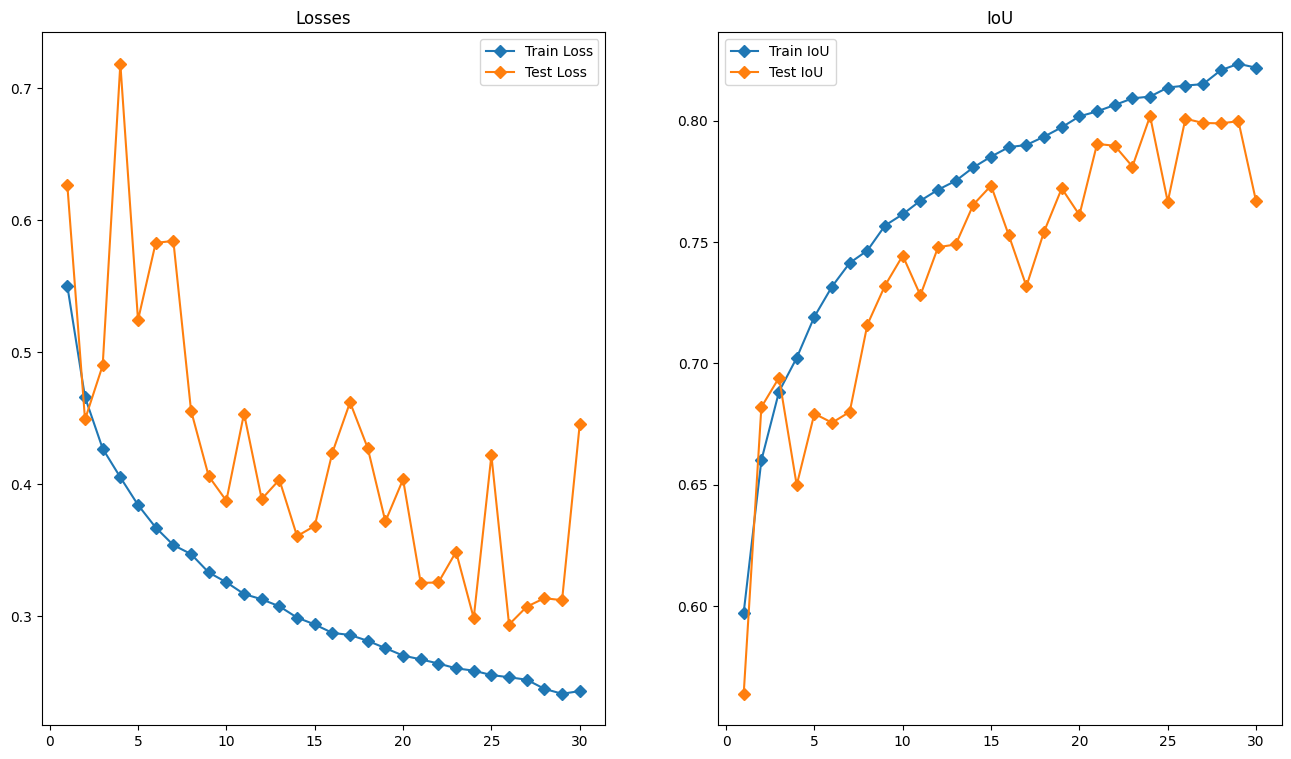

In [31]:
plot_history(history)

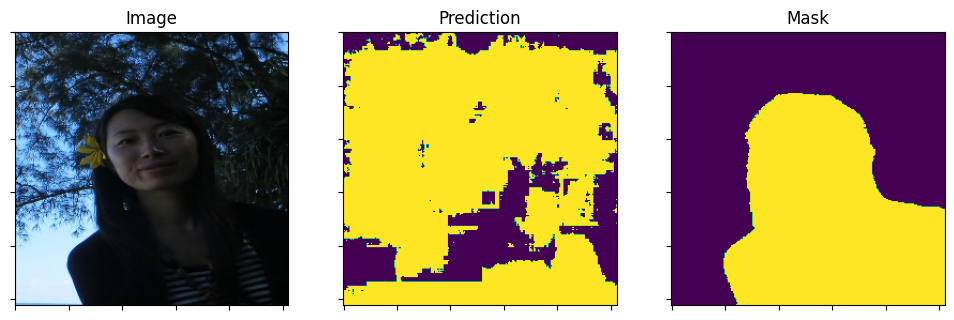

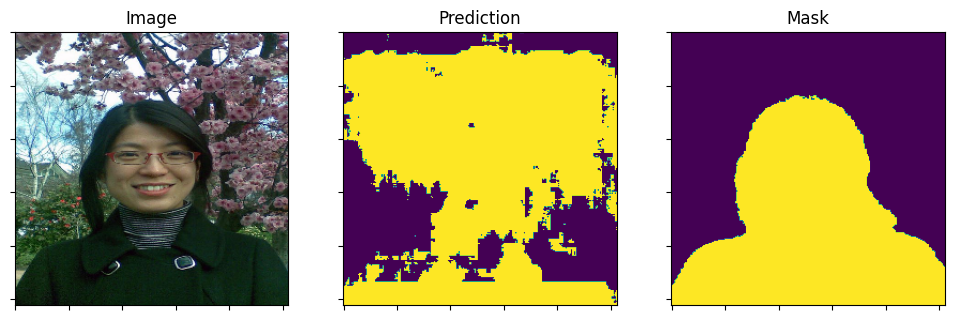

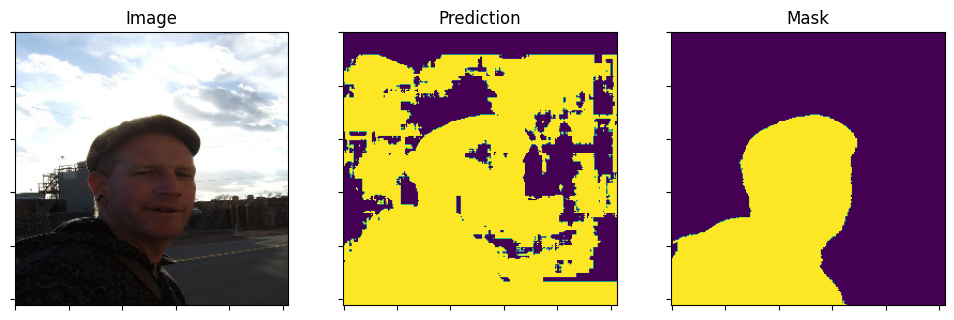

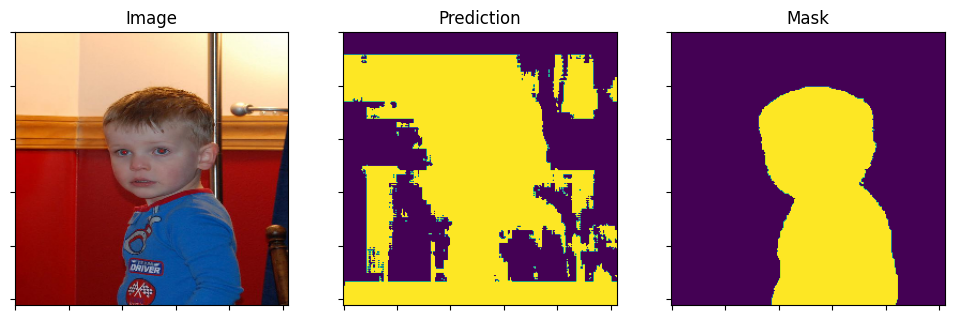

In [32]:
visualizeTopNWorst(model, test_dataset, 4)

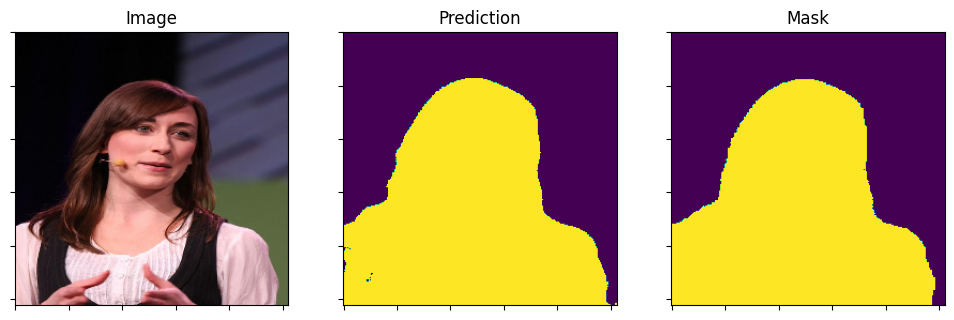

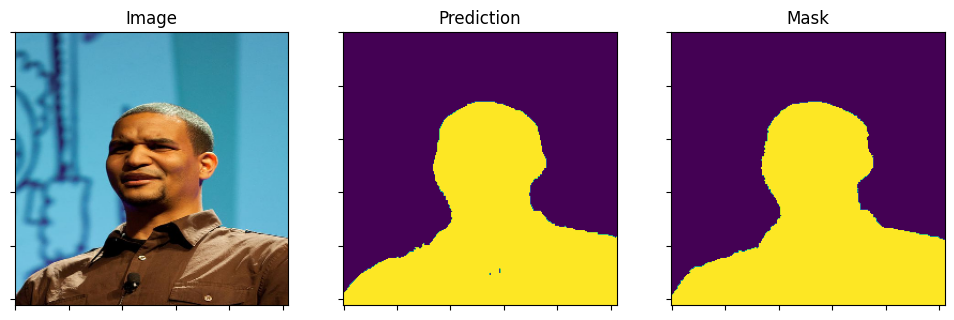

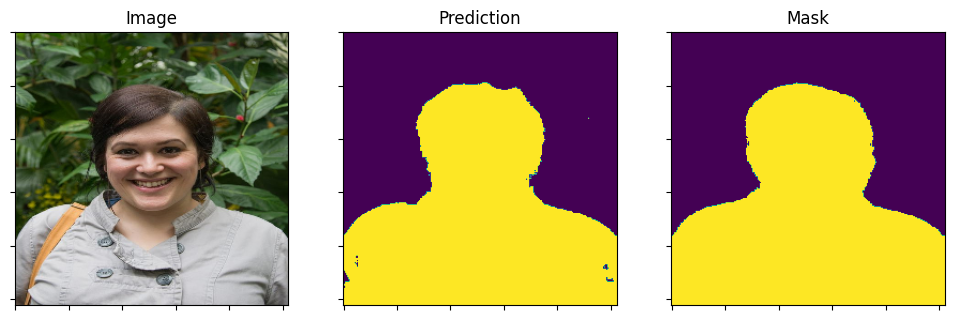

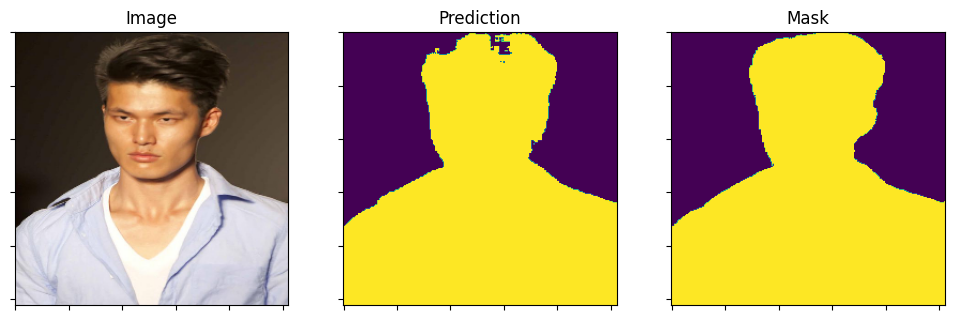

In [33]:
visualizeTopNBest(model, test_dataset, 4)

Как видно, двух downsample'ов не хватает

## KFold

In [20]:
class KFoldUnet(nn.Module):
    def __init__(self, models, dataset, n_splits=5):
        self.kfold = KFold(n_splits=n_splits, shuffle=True)
        self.models = models

        self.train_indices = []
        self.test_indices = []

        for train_indices, test_indices in self.kfold.split(dataset):
            self.train_indices.append(train_indices)
            self.test_indices.append(test_indices)

    def get_model(self, i):
        return self.models[i]

    def get_train_indices(self, i):
        return self.train_indices[i]

    def get_test_indices(self, i):
        return self.test_indices[i]

In [21]:
N_SAMPLES = 5

In [22]:
all_dataset = FacesDataset(images, masks, transforms=get_transforms())

kfold_unet = KFoldUnet([UNet(3, 16, 1) for _ in range(N_SAMPLES)], all_dataset, N_SAMPLES)

In [23]:
histories = []

for i in range(N_SAMPLES):
    model = kfold_unet.get_model(i)
    loss_fn = nn.BCEWithLogitsLoss()
    optim = torch.optim.Adam(model.parameters())

    train_loader = torch.utils.data.DataLoader(
        all_dataset, 
        batch_size=BATCH_SIZE,
        sampler=torch.utils.data.SubsetRandomSampler(kfold_unet.get_train_indices(i))
    )
    test_loader = torch.utils.data.DataLoader(
        all_dataset, 
        batch_size=BATCH_SIZE,
        sampler=torch.utils.data.SubsetRandomSampler(kfold_unet.get_test_indices(i))
    )

    histories.append(train(model, optim, loss_fn, train_loader, test_loader))

Epoch 1/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.40it/s]


Epoch 1: Train Loss: 0.3512, Train IoU: 0.5687 | Test Loss: 0.0603, Test IoU: 0.1584


Epoch 2/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 2: Train Loss: 0.2088, Train IoU: 0.6892 | Test Loss: 0.0449, Test IoU: 0.1749


Epoch 3/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.44it/s]


Epoch 3: Train Loss: 0.1474, Train IoU: 0.7196 | Test Loss: 0.0341, Test IoU: 0.1804


Epoch 4/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


Epoch 4: Train Loss: 0.1141, Train IoU: 0.7350 | Test Loss: 0.0290, Test IoU: 0.1820


Epoch 5/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]


Epoch 5: Train Loss: 0.0949, Train IoU: 0.7431 | Test Loss: 0.0262, Test IoU: 0.1832


Epoch 6/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.41it/s]


Epoch 6: Train Loss: 0.0797, Train IoU: 0.7513 | Test Loss: 0.0311, Test IoU: 0.1797


Epoch 7/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.42it/s]


Epoch 7: Train Loss: 0.0693, Train IoU: 0.7572 | Test Loss: 0.0190, Test IoU: 0.1879


Epoch 8/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]


Epoch 8: Train Loss: 0.0595, Train IoU: 0.7627 | Test Loss: 0.0185, Test IoU: 0.1880


Epoch 9/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.41it/s]


Epoch 9: Train Loss: 0.0546, Train IoU: 0.7653 | Test Loss: 0.0178, Test IoU: 0.1882


Epoch 10/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.44it/s]


Epoch 10: Train Loss: 0.0461, Train IoU: 0.7705 | Test Loss: 0.0160, Test IoU: 0.1896


Epoch 11/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.31it/s]


Epoch 11: Train Loss: 0.0411, Train IoU: 0.7735 | Test Loss: 0.0171, Test IoU: 0.1890


Epoch 12/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.47it/s]


Epoch 12: Train Loss: 0.0374, Train IoU: 0.7759 | Test Loss: 0.0148, Test IoU: 0.1903


Epoch 13/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]


Epoch 13: Train Loss: 0.0354, Train IoU: 0.7764 | Test Loss: 0.0183, Test IoU: 0.1878


Epoch 14/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.49it/s]


Epoch 14: Train Loss: 0.0330, Train IoU: 0.7781 | Test Loss: 0.0141, Test IoU: 0.1910


Epoch 15/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 15: Train Loss: 0.0296, Train IoU: 0.7802 | Test Loss: 0.0131, Test IoU: 0.1913


Epoch 16/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.40it/s]


Epoch 16: Train Loss: 0.0258, Train IoU: 0.7828 | Test Loss: 0.0131, Test IoU: 0.1916


Epoch 17/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.39it/s]


Epoch 17: Train Loss: 0.0235, Train IoU: 0.7843 | Test Loss: 0.0126, Test IoU: 0.1921


Epoch 18/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.41it/s]


Epoch 18: Train Loss: 0.0206, Train IoU: 0.7861 | Test Loss: 0.0129, Test IoU: 0.1920


Epoch 19/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.47it/s]


Epoch 19: Train Loss: 0.0195, Train IoU: 0.7866 | Test Loss: 0.0133, Test IoU: 0.1918


Epoch 20/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.41it/s]


Epoch 20: Train Loss: 0.0199, Train IoU: 0.7863 | Test Loss: 0.0140, Test IoU: 0.1915


Epoch 21/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.39it/s]


Epoch 21: Train Loss: 0.0198, Train IoU: 0.7862 | Test Loss: 0.0148, Test IoU: 0.1911


Epoch 22/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.37it/s]


Epoch 22: Train Loss: 0.0238, Train IoU: 0.7833 | Test Loss: 0.0198, Test IoU: 0.1884


Epoch 23/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.36it/s]


Epoch 23: Train Loss: 0.0257, Train IoU: 0.7819 | Test Loss: 0.0150, Test IoU: 0.1913


Epoch 24/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


Epoch 24: Train Loss: 0.0210, Train IoU: 0.7851 | Test Loss: 0.0164, Test IoU: 0.1904


Epoch 25/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.39it/s]


Epoch 25: Train Loss: 0.0189, Train IoU: 0.7864 | Test Loss: 0.0126, Test IoU: 0.1923


Epoch 26/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.40it/s]


Epoch 26: Train Loss: 0.0156, Train IoU: 0.7888 | Test Loss: 0.0128, Test IoU: 0.1926


Epoch 27/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.40it/s]


Epoch 27: Train Loss: 0.0145, Train IoU: 0.7894 | Test Loss: 0.0131, Test IoU: 0.1924


Epoch 28/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.42it/s]


Epoch 28: Train Loss: 0.0152, Train IoU: 0.7889 | Test Loss: 0.0140, Test IoU: 0.1921


Epoch 29/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.36it/s]


Epoch 29: Train Loss: 0.0142, Train IoU: 0.7895 | Test Loss: 0.0137, Test IoU: 0.1924


Epoch 30/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]


Epoch 30: Train Loss: 0.0132, Train IoU: 0.7903 | Test Loss: 0.0141, Test IoU: 0.1925


Epoch 1/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.39it/s]


Epoch 1: Train Loss: 0.3706, Train IoU: 0.5574 | Test Loss: 0.0710, Test IoU: 0.1490


Epoch 2/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]


Epoch 2: Train Loss: 0.2224, Train IoU: 0.6767 | Test Loss: 0.0495, Test IoU: 0.1742


Epoch 3/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.40it/s]


Epoch 3: Train Loss: 0.1589, Train IoU: 0.7074 | Test Loss: 0.0410, Test IoU: 0.1766


Epoch 4/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.41it/s]


Epoch 4: Train Loss: 0.1240, Train IoU: 0.7254 | Test Loss: 0.0285, Test IoU: 0.1835


Epoch 5/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.39it/s]


Epoch 5: Train Loss: 0.0999, Train IoU: 0.7390 | Test Loss: 0.0251, Test IoU: 0.1847


Epoch 6/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.39it/s]


Epoch 6: Train Loss: 0.0827, Train IoU: 0.7485 | Test Loss: 0.0244, Test IoU: 0.1845


Epoch 7/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


Epoch 7: Train Loss: 0.0768, Train IoU: 0.7501 | Test Loss: 0.0215, Test IoU: 0.1865


Epoch 8/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.38it/s]


Epoch 8: Train Loss: 0.0655, Train IoU: 0.7580 | Test Loss: 0.0188, Test IoU: 0.1879


Epoch 9/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.40it/s]


Epoch 9: Train Loss: 0.0559, Train IoU: 0.7643 | Test Loss: 0.0188, Test IoU: 0.1879


Epoch 10/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.37it/s]


Epoch 10: Train Loss: 0.0522, Train IoU: 0.7655 | Test Loss: 0.0184, Test IoU: 0.1879


Epoch 11/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.36it/s]


Epoch 11: Train Loss: 0.0484, Train IoU: 0.7677 | Test Loss: 0.0166, Test IoU: 0.1896


Epoch 12/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.37it/s]


Epoch 12: Train Loss: 0.0447, Train IoU: 0.7701 | Test Loss: 0.0152, Test IoU: 0.1900


Epoch 13/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.41it/s]


Epoch 13: Train Loss: 0.0389, Train IoU: 0.7741 | Test Loss: 0.0151, Test IoU: 0.1901


Epoch 14/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.44it/s]


Epoch 14: Train Loss: 0.0352, Train IoU: 0.7765 | Test Loss: 0.0142, Test IoU: 0.1911


Epoch 15/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.39it/s]


Epoch 15: Train Loss: 0.0331, Train IoU: 0.7775 | Test Loss: 0.0151, Test IoU: 0.1907


Epoch 16/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.41it/s]


Epoch 16: Train Loss: 0.0284, Train IoU: 0.7808 | Test Loss: 0.0137, Test IoU: 0.1913


Epoch 17/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.39it/s]


Epoch 17: Train Loss: 0.0266, Train IoU: 0.7818 | Test Loss: 0.0151, Test IoU: 0.1904


Epoch 18/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.49it/s]


Epoch 18: Train Loss: 0.0261, Train IoU: 0.7818 | Test Loss: 0.0142, Test IoU: 0.1910


Epoch 19/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.38it/s]


Epoch 19: Train Loss: 0.0266, Train IoU: 0.7814 | Test Loss: 0.0151, Test IoU: 0.1910


Epoch 20/30 (Test): 100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


Epoch 20: Train Loss: 0.0241, Train IoU: 0.7829 | Test Loss: 0.0149, Test IoU: 0.1908


Epoch 21/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.41it/s]


Epoch 21: Train Loss: 0.0279, Train IoU: 0.7805 | Test Loss: 0.0226, Test IoU: 0.1883


Epoch 22/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.47it/s]


Epoch 22: Train Loss: 0.0284, Train IoU: 0.7798 | Test Loss: 0.0128, Test IoU: 0.1921


Epoch 23/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.36it/s]


Epoch 23: Train Loss: 0.0225, Train IoU: 0.7839 | Test Loss: 0.0126, Test IoU: 0.1921


Epoch 24/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.34it/s]


Epoch 24: Train Loss: 0.0269, Train IoU: 0.7806 | Test Loss: 0.0221, Test IoU: 0.1868


Epoch 25/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.38it/s]


Epoch 25: Train Loss: 0.0225, Train IoU: 0.7837 | Test Loss: 0.0138, Test IoU: 0.1911


Epoch 26/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.40it/s]


Epoch 26: Train Loss: 0.0182, Train IoU: 0.7869 | Test Loss: 0.0122, Test IoU: 0.1924


Epoch 27/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.41it/s]


Epoch 27: Train Loss: 0.0176, Train IoU: 0.7872 | Test Loss: 0.0119, Test IoU: 0.1927


Epoch 28/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.38it/s]


Epoch 28: Train Loss: 0.0176, Train IoU: 0.7871 | Test Loss: 0.0121, Test IoU: 0.1925


Epoch 29/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.40it/s]


Epoch 29: Train Loss: 0.0157, Train IoU: 0.7884 | Test Loss: 0.0122, Test IoU: 0.1929


Epoch 30/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.42it/s]


Epoch 30: Train Loss: 0.0145, Train IoU: 0.7892 | Test Loss: 0.0121, Test IoU: 0.1930


Epoch 1/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.42it/s]


Epoch 1: Train Loss: 0.3637, Train IoU: 0.5651 | Test Loss: 0.0671, Test IoU: 0.1594


Epoch 2/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.41it/s]


Epoch 2: Train Loss: 0.2213, Train IoU: 0.6875 | Test Loss: 0.0483, Test IoU: 0.1726


Epoch 3/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 3: Train Loss: 0.1606, Train IoU: 0.7116 | Test Loss: 0.0365, Test IoU: 0.1794


Epoch 4/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.39it/s]


Epoch 4: Train Loss: 0.1213, Train IoU: 0.7321 | Test Loss: 0.0282, Test IoU: 0.1837


Epoch 5/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.41it/s]


Epoch 5: Train Loss: 0.0990, Train IoU: 0.7421 | Test Loss: 0.0258, Test IoU: 0.1840


Epoch 6/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.40it/s]


Epoch 6: Train Loss: 0.0818, Train IoU: 0.7509 | Test Loss: 0.0250, Test IoU: 0.1836


Epoch 7/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.39it/s]


Epoch 7: Train Loss: 0.0702, Train IoU: 0.7574 | Test Loss: 0.0228, Test IoU: 0.1859


Epoch 8/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.41it/s]


Epoch 8: Train Loss: 0.0601, Train IoU: 0.7633 | Test Loss: 0.0173, Test IoU: 0.1886


Epoch 9/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.37it/s]


Epoch 9: Train Loss: 0.0533, Train IoU: 0.7669 | Test Loss: 0.0190, Test IoU: 0.1873


Epoch 10/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.42it/s]


Epoch 10: Train Loss: 0.0464, Train IoU: 0.7707 | Test Loss: 0.0172, Test IoU: 0.1886


Epoch 11/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.38it/s]


Epoch 11: Train Loss: 0.0402, Train IoU: 0.7744 | Test Loss: 0.0161, Test IoU: 0.1895


Epoch 12/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


Epoch 12: Train Loss: 0.0396, Train IoU: 0.7739 | Test Loss: 0.0144, Test IoU: 0.1903


Epoch 13/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.41it/s]


Epoch 13: Train Loss: 0.0347, Train IoU: 0.7773 | Test Loss: 0.0152, Test IoU: 0.1899


Epoch 14/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.41it/s]


Epoch 14: Train Loss: 0.0351, Train IoU: 0.7767 | Test Loss: 0.0148, Test IoU: 0.1901


Epoch 15/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.40it/s]


Epoch 15: Train Loss: 0.0303, Train IoU: 0.7799 | Test Loss: 0.0134, Test IoU: 0.1914


Epoch 16/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


Epoch 16: Train Loss: 0.0282, Train IoU: 0.7812 | Test Loss: 0.0137, Test IoU: 0.1913


Epoch 17/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.39it/s]


Epoch 17: Train Loss: 0.0288, Train IoU: 0.7804 | Test Loss: 0.0144, Test IoU: 0.1904


Epoch 18/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.41it/s]


Epoch 18: Train Loss: 0.0248, Train IoU: 0.7832 | Test Loss: 0.0128, Test IoU: 0.1920


Epoch 19/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.42it/s]


Epoch 19: Train Loss: 0.0223, Train IoU: 0.7849 | Test Loss: 0.0128, Test IoU: 0.1919


Epoch 20/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.39it/s]


Epoch 20: Train Loss: 0.0268, Train IoU: 0.7812 | Test Loss: 0.0155, Test IoU: 0.1899


Epoch 21/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.39it/s]


Epoch 21: Train Loss: 0.0251, Train IoU: 0.7825 | Test Loss: 0.0133, Test IoU: 0.1914


Epoch 22/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.42it/s]


Epoch 22: Train Loss: 0.0220, Train IoU: 0.7845 | Test Loss: 0.0134, Test IoU: 0.1918


Epoch 23/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.40it/s]


Epoch 23: Train Loss: 0.0184, Train IoU: 0.7871 | Test Loss: 0.0118, Test IoU: 0.1929


Epoch 24/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.44it/s]


Epoch 24: Train Loss: 0.0171, Train IoU: 0.7878 | Test Loss: 0.0110, Test IoU: 0.1932


Epoch 25/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


Epoch 25: Train Loss: 0.0155, Train IoU: 0.7889 | Test Loss: 0.0127, Test IoU: 0.1925


Epoch 26/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.45it/s]


Epoch 26: Train Loss: 0.0151, Train IoU: 0.7892 | Test Loss: 0.0116, Test IoU: 0.1933


Epoch 27/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.40it/s]


Epoch 27: Train Loss: 0.0150, Train IoU: 0.7892 | Test Loss: 0.0127, Test IoU: 0.1926


Epoch 28/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]


Epoch 28: Train Loss: 0.0146, Train IoU: 0.7894 | Test Loss: 0.0122, Test IoU: 0.1929


Epoch 29/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.34it/s]


Epoch 29: Train Loss: 0.0145, Train IoU: 0.7895 | Test Loss: 0.0134, Test IoU: 0.1924


Epoch 30/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]


Epoch 30: Train Loss: 0.0148, Train IoU: 0.7891 | Test Loss: 0.0122, Test IoU: 0.1930


Epoch 1/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.45it/s]


Epoch 1: Train Loss: 0.3427, Train IoU: 0.5934 | Test Loss: 0.0566, Test IoU: 0.1628


Epoch 2/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.47it/s]


Epoch 2: Train Loss: 0.2003, Train IoU: 0.6938 | Test Loss: 0.0467, Test IoU: 0.1754


Epoch 3/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.47it/s]


Epoch 3: Train Loss: 0.1415, Train IoU: 0.7219 | Test Loss: 0.0476, Test IoU: 0.1679


Epoch 4/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]


Epoch 4: Train Loss: 0.1120, Train IoU: 0.7342 | Test Loss: 0.0307, Test IoU: 0.1803


Epoch 5/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.48it/s]


Epoch 5: Train Loss: 0.0901, Train IoU: 0.7458 | Test Loss: 0.0239, Test IoU: 0.1847


Epoch 6/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.49it/s]


Epoch 6: Train Loss: 0.0755, Train IoU: 0.7536 | Test Loss: 0.0232, Test IoU: 0.1849


Epoch 7/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.48it/s]


Epoch 7: Train Loss: 0.0710, Train IoU: 0.7548 | Test Loss: 0.0242, Test IoU: 0.1834


Epoch 8/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.37it/s]


Epoch 8: Train Loss: 0.0628, Train IoU: 0.7594 | Test Loss: 0.0201, Test IoU: 0.1866


Epoch 9/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.41it/s]


Epoch 9: Train Loss: 0.0540, Train IoU: 0.7649 | Test Loss: 0.0165, Test IoU: 0.1888


Epoch 10/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.48it/s]


Epoch 10: Train Loss: 0.0449, Train IoU: 0.7713 | Test Loss: 0.0218, Test IoU: 0.1850


Epoch 11/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.45it/s]


Epoch 11: Train Loss: 0.0409, Train IoU: 0.7731 | Test Loss: 0.0168, Test IoU: 0.1888


Epoch 12/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.33it/s]


Epoch 12: Train Loss: 0.0384, Train IoU: 0.7745 | Test Loss: 0.0162, Test IoU: 0.1894


Epoch 13/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.45it/s]


Epoch 13: Train Loss: 0.0370, Train IoU: 0.7753 | Test Loss: 0.0153, Test IoU: 0.1897


Epoch 14/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.46it/s]


Epoch 14: Train Loss: 0.0315, Train IoU: 0.7788 | Test Loss: 0.0134, Test IoU: 0.1912


Epoch 15/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]


Epoch 15: Train Loss: 0.0300, Train IoU: 0.7797 | Test Loss: 0.0156, Test IoU: 0.1900


Epoch 16/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.39it/s]


Epoch 16: Train Loss: 0.0267, Train IoU: 0.7818 | Test Loss: 0.0139, Test IoU: 0.1913


Epoch 17/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]


Epoch 17: Train Loss: 0.0257, Train IoU: 0.7822 | Test Loss: 0.0134, Test IoU: 0.1915


Epoch 18/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]


Epoch 18: Train Loss: 0.0255, Train IoU: 0.7822 | Test Loss: 0.0137, Test IoU: 0.1912


Epoch 19/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.44it/s]


Epoch 19: Train Loss: 0.0230, Train IoU: 0.7840 | Test Loss: 0.0152, Test IoU: 0.1906


Epoch 20/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.45it/s]


Epoch 20: Train Loss: 0.0261, Train IoU: 0.7814 | Test Loss: 0.0152, Test IoU: 0.1905


Epoch 21/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]


Epoch 21: Train Loss: 0.0215, Train IoU: 0.7847 | Test Loss: 0.0146, Test IoU: 0.1910


Epoch 22/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.45it/s]


Epoch 22: Train Loss: 0.0204, Train IoU: 0.7855 | Test Loss: 0.0146, Test IoU: 0.1914


Epoch 23/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.42it/s]


Epoch 23: Train Loss: 0.0191, Train IoU: 0.7862 | Test Loss: 0.0153, Test IoU: 0.1908


Epoch 24/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.50it/s]


Epoch 24: Train Loss: 0.0164, Train IoU: 0.7883 | Test Loss: 0.0133, Test IoU: 0.1925


Epoch 25/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


Epoch 25: Train Loss: 0.0150, Train IoU: 0.7891 | Test Loss: 0.0142, Test IoU: 0.1922


Epoch 26/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.45it/s]


Epoch 26: Train Loss: 0.0149, Train IoU: 0.7891 | Test Loss: 0.0139, Test IoU: 0.1922


Epoch 27/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.48it/s]


Epoch 27: Train Loss: 0.0138, Train IoU: 0.7898 | Test Loss: 0.0140, Test IoU: 0.1922


Epoch 28/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.46it/s]


Epoch 28: Train Loss: 0.0138, Train IoU: 0.7897 | Test Loss: 0.0161, Test IoU: 0.1914


Epoch 29/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.34it/s]


Epoch 29: Train Loss: 0.0155, Train IoU: 0.7885 | Test Loss: 0.0180, Test IoU: 0.1904


Epoch 30/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]


Epoch 30: Train Loss: 0.0178, Train IoU: 0.7868 | Test Loss: 0.0158, Test IoU: 0.1914


Epoch 1/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.47it/s]


Epoch 1: Train Loss: 0.3775, Train IoU: 0.5817 | Test Loss: 0.0635, Test IoU: 0.1598


Epoch 2/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.44it/s]


Epoch 2: Train Loss: 0.2407, Train IoU: 0.6863 | Test Loss: 0.0502, Test IoU: 0.1761


Epoch 3/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.46it/s]


Epoch 3: Train Loss: 0.1781, Train IoU: 0.7142 | Test Loss: 0.0403, Test IoU: 0.1776


Epoch 4/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.45it/s]


Epoch 4: Train Loss: 0.1444, Train IoU: 0.7245 | Test Loss: 0.0328, Test IoU: 0.1823


Epoch 5/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.47it/s]


Epoch 5: Train Loss: 0.1137, Train IoU: 0.7399 | Test Loss: 0.0257, Test IoU: 0.1859


Epoch 6/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.47it/s]


Epoch 6: Train Loss: 0.0957, Train IoU: 0.7470 | Test Loss: 0.0251, Test IoU: 0.1849


Epoch 7/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.39it/s]


Epoch 7: Train Loss: 0.0867, Train IoU: 0.7495 | Test Loss: 0.0263, Test IoU: 0.1849


Epoch 8/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.36it/s]


Epoch 8: Train Loss: 0.0735, Train IoU: 0.7568 | Test Loss: 0.0195, Test IoU: 0.1885


Epoch 9/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]


Epoch 9: Train Loss: 0.0640, Train IoU: 0.7615 | Test Loss: 0.0187, Test IoU: 0.1888


Epoch 10/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.49it/s]


Epoch 10: Train Loss: 0.0532, Train IoU: 0.7685 | Test Loss: 0.0157, Test IoU: 0.1903


Epoch 11/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]


Epoch 11: Train Loss: 0.0526, Train IoU: 0.7673 | Test Loss: 0.0161, Test IoU: 0.1899


Epoch 12/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.34it/s]


Epoch 12: Train Loss: 0.0470, Train IoU: 0.7707 | Test Loss: 0.0165, Test IoU: 0.1891


Epoch 13/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.31it/s]


Epoch 13: Train Loss: 0.0449, Train IoU: 0.7715 | Test Loss: 0.0171, Test IoU: 0.1893


Epoch 14/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.42it/s]


Epoch 14: Train Loss: 0.0371, Train IoU: 0.7769 | Test Loss: 0.0134, Test IoU: 0.1913


Epoch 15/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.40it/s]


Epoch 15: Train Loss: 0.0302, Train IoU: 0.7815 | Test Loss: 0.0148, Test IoU: 0.1912


Epoch 16/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.45it/s]


Epoch 16: Train Loss: 0.0276, Train IoU: 0.7827 | Test Loss: 0.0137, Test IoU: 0.1915


Epoch 17/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.44it/s]


Epoch 17: Train Loss: 0.0266, Train IoU: 0.7831 | Test Loss: 0.0145, Test IoU: 0.1910


Epoch 18/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.48it/s]


Epoch 18: Train Loss: 0.0327, Train IoU: 0.7781 | Test Loss: 0.0168, Test IoU: 0.1899


Epoch 19/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.48it/s]


Epoch 19: Train Loss: 0.0304, Train IoU: 0.7795 | Test Loss: 0.0160, Test IoU: 0.1902


Epoch 20/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.48it/s]


Epoch 20: Train Loss: 0.0274, Train IoU: 0.7817 | Test Loss: 0.0141, Test IoU: 0.1908


Epoch 21/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.34it/s]


Epoch 21: Train Loss: 0.0299, Train IoU: 0.7793 | Test Loss: 0.0158, Test IoU: 0.1905


Epoch 22/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.47it/s]


Epoch 22: Train Loss: 0.0256, Train IoU: 0.7826 | Test Loss: 0.0125, Test IoU: 0.1919


Epoch 23/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.46it/s]


Epoch 23: Train Loss: 0.0206, Train IoU: 0.7860 | Test Loss: 0.0133, Test IoU: 0.1920


Epoch 24/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.48it/s]


Epoch 24: Train Loss: 0.0186, Train IoU: 0.7873 | Test Loss: 0.0124, Test IoU: 0.1927


Epoch 25/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.33it/s]


Epoch 25: Train Loss: 0.0177, Train IoU: 0.7878 | Test Loss: 0.0136, Test IoU: 0.1924


Epoch 26/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.49it/s]


Epoch 26: Train Loss: 0.0159, Train IoU: 0.7890 | Test Loss: 0.0137, Test IoU: 0.1925


Epoch 27/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.41it/s]


Epoch 27: Train Loss: 0.0150, Train IoU: 0.7896 | Test Loss: 0.0120, Test IoU: 0.1931


Epoch 28/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.47it/s]


Epoch 28: Train Loss: 0.0148, Train IoU: 0.7896 | Test Loss: 0.0129, Test IoU: 0.1928


Epoch 29/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.47it/s]


Epoch 29: Train Loss: 0.0145, Train IoU: 0.7897 | Test Loss: 0.0125, Test IoU: 0.1930


Epoch 30/30 (Test): 100%|██████████| 13/13 [00:03<00:00,  3.48it/s]

Epoch 30: Train Loss: 0.0139, Train IoU: 0.7901 | Test Loss: 0.0131, Test IoU: 0.1929


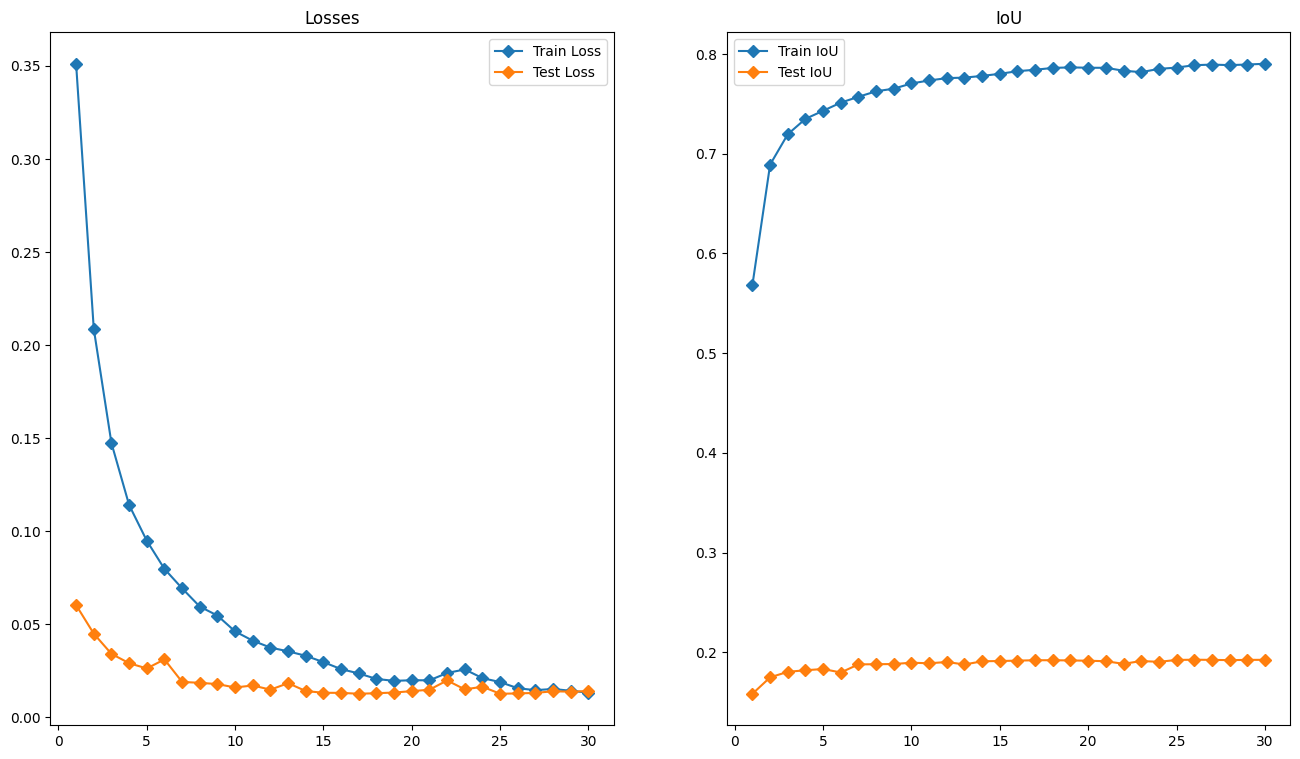

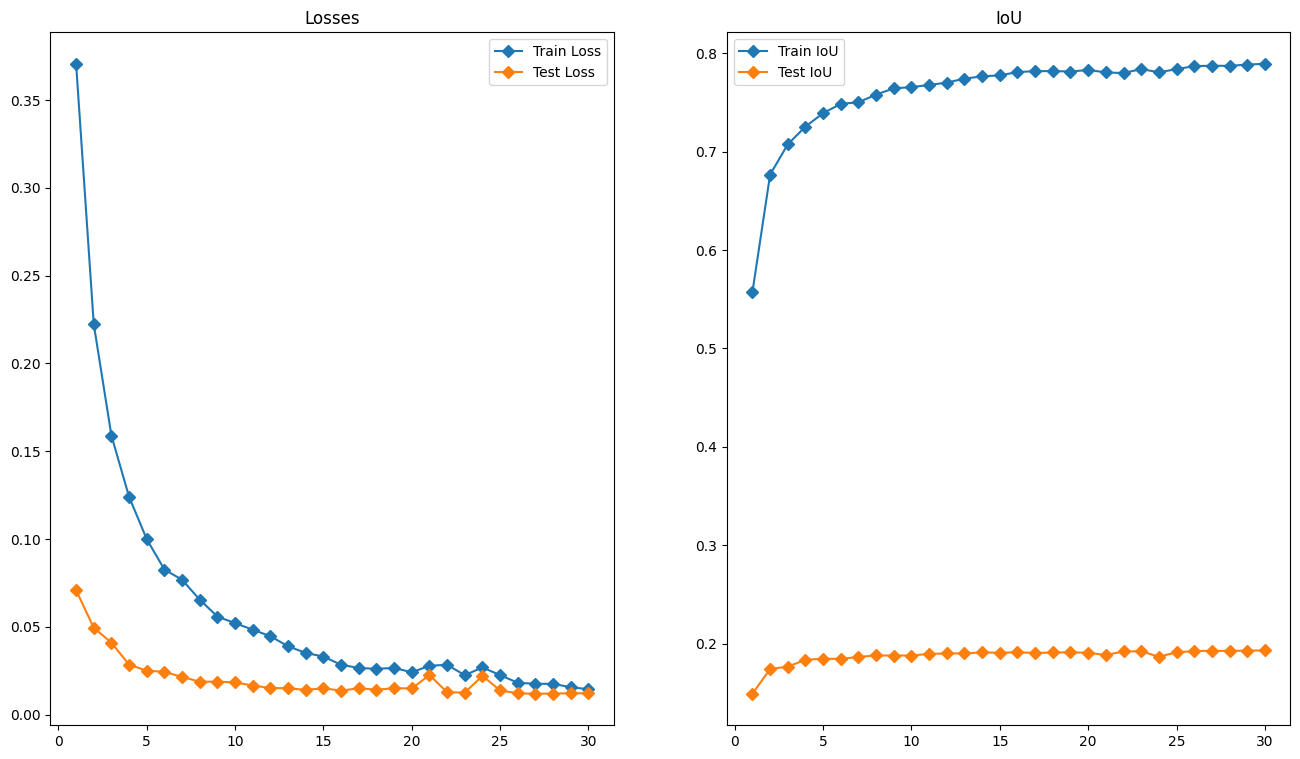

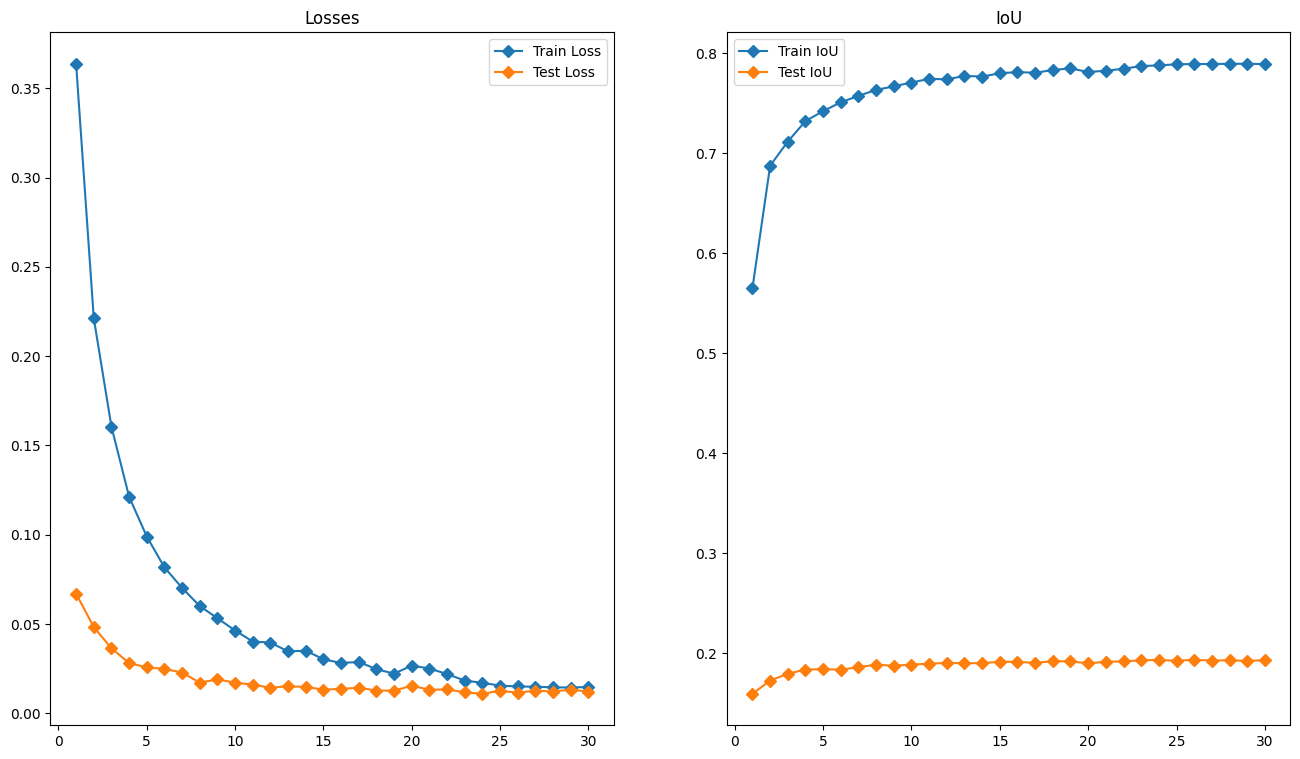

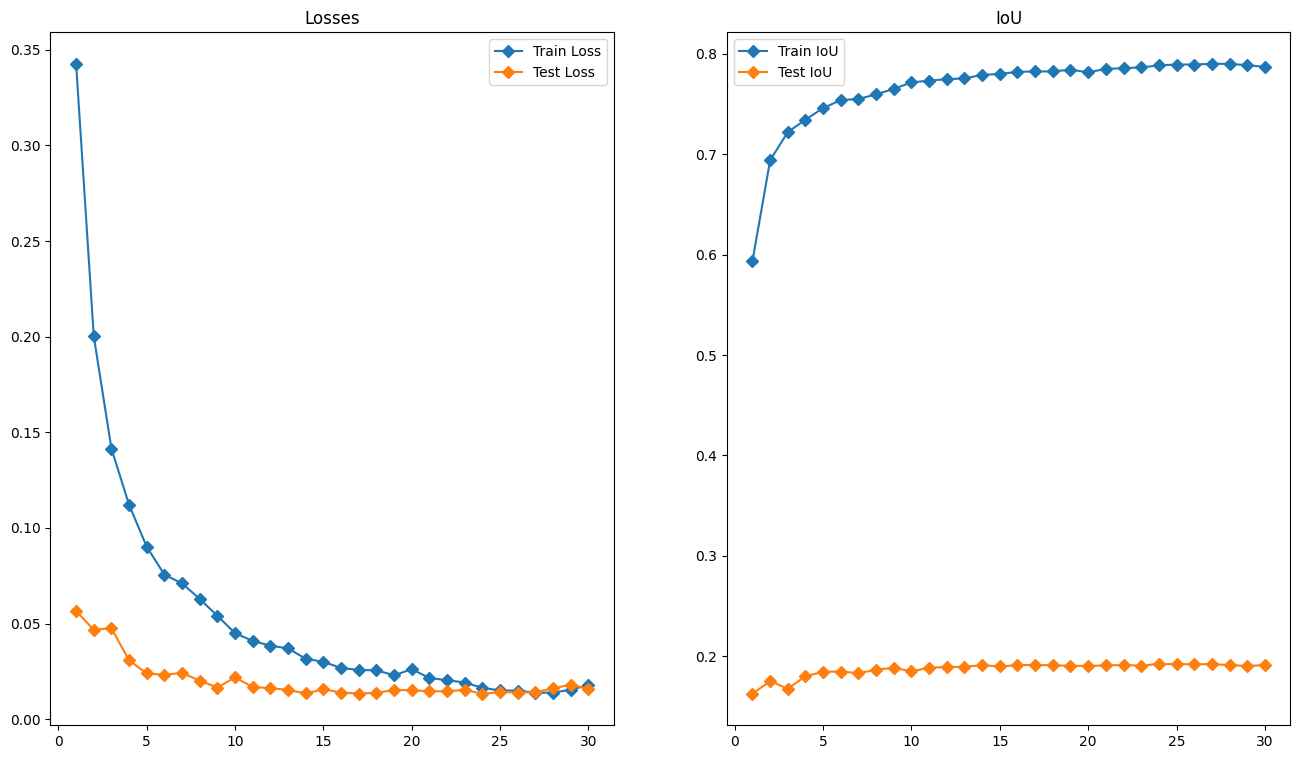

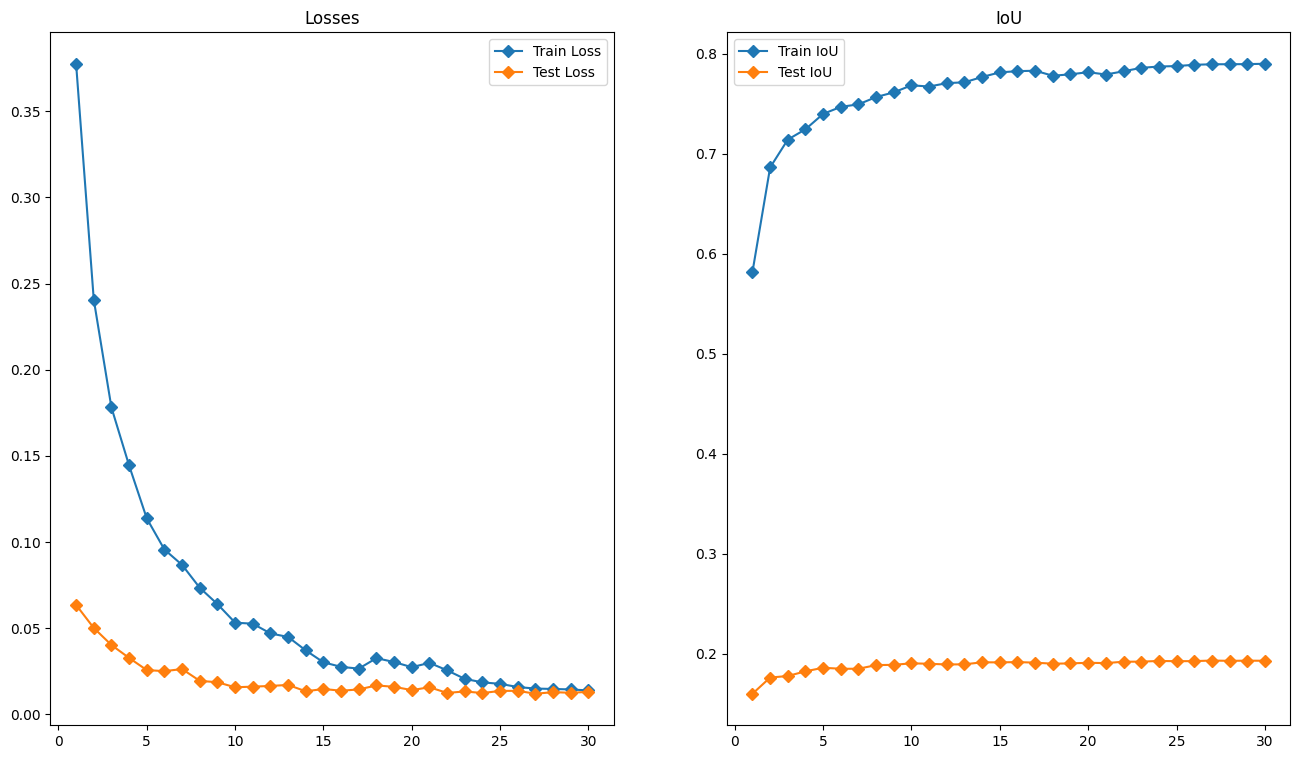

In [24]:
for history in histories:
    plot_history(history)

In [25]:
def eval_assamble(models, image):
    preds = []
    for model in models:
        model.eval()
        with torch.no_grad():
            pred = model(image)
            preds.append(pred)

    return torch.cat(preds, dim=1).mean(dim=1)

In [26]:
iou = 0
count = 0
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

for image, mask in tqdm(test_loader):
    count += 1
    image = image.to(DEVICE)
    mask = mask.to(DEVICE)
    pred = eval_assamble(kfold_unet.models, image)
    iou += iou_score(pred, mask)

iou /= count

print(f"IoU for KFold Unet: {iou}")

100%|██████████| 13/13 [00:05<00:00,  2.25it/s]

IoU for KFold Unet: 0.9886814310000493


На тестовой выборке IoU для ансамбля оказался лучше примерно на 0.2, чем для одной модели (даже аугментированной)

In [27]:
def visualizeTopNWorstFold(models, test_dataset, n):
    model.eval()
    ious = []
    for i, (image, mask) in enumerate(test_dataset):
        with torch.no_grad():
            pred = eval_assamble(kfold_unet.models, torch.from_numpy(image).to(DEVICE).unsqueeze(0))
            iou = iou_score(pred, torch.from_numpy(mask).to(DEVICE))
            ious.extend([(iou, i)])
    ious = sorted(ious, key=lambda x: x[0])[:n]
    data = []
    for _, i in ious:
        image, mask = test_dataset[i]
        with torch.no_grad():
            pred = model(torch.from_numpy(image).to(DEVICE).unsqueeze(0)).squeeze()
        pred = (torch.sigmoid(pred) >= 0.5).float()
        data.append((image.transpose(1, 2, 0), pred.cpu().numpy(), mask))
    visualize(data, titles=["Image", "Prediction", "Mask"])

In [29]:
def visualizeTopNBestFold(models, test_dataset, n):
    model.eval()
    ious = []
    for i, (image, mask) in enumerate(test_dataset):
        with torch.no_grad():
            pred = eval_assamble(kfold_unet.models, torch.from_numpy(image).to(DEVICE).unsqueeze(0))
            iou = iou_score(pred, torch.from_numpy(mask).to(DEVICE))
            ious.extend([(iou, i)])
    ious = sorted(ious, key=lambda x: x[0], reverse=True)[:n]
    data = []
    for _, i in ious:
        image, mask = test_dataset[i]
        with torch.no_grad():
            pred = model(torch.from_numpy(image).to(DEVICE).unsqueeze(0)).squeeze()
        pred = (torch.sigmoid(pred) >= 0.5).float()
        data.append((image.transpose(1, 2, 0), pred.cpu().numpy(), mask))
    visualize(data, titles=["Image", "Prediction", "Mask"])

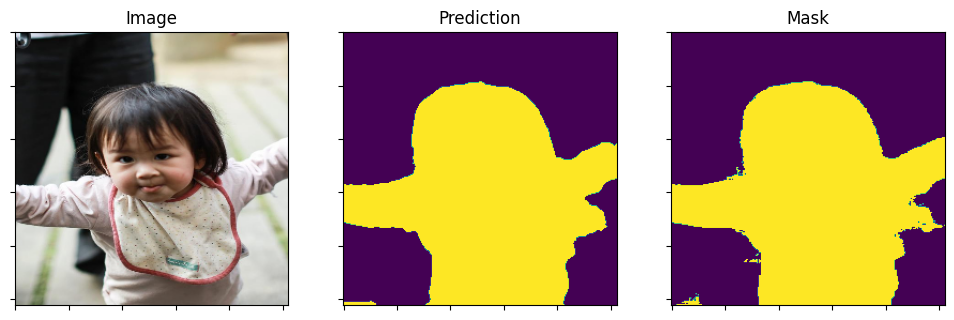

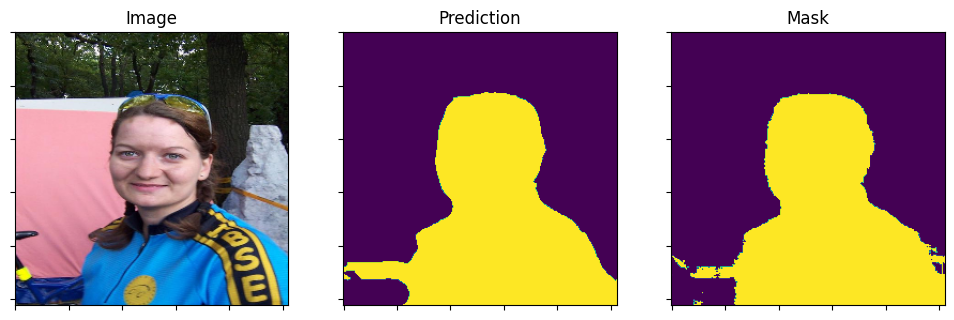

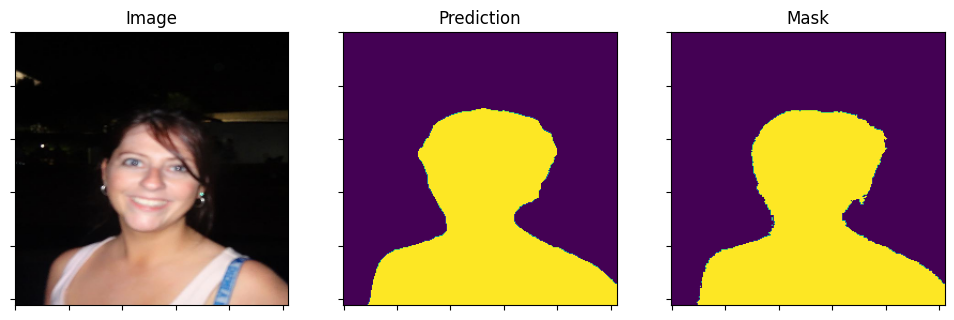

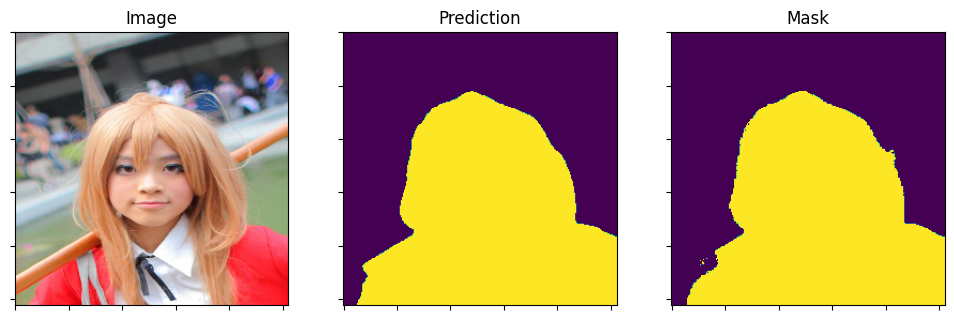

In [30]:
visualizeTopNWorstFold(kfold_unet.models, test_dataset, 4)

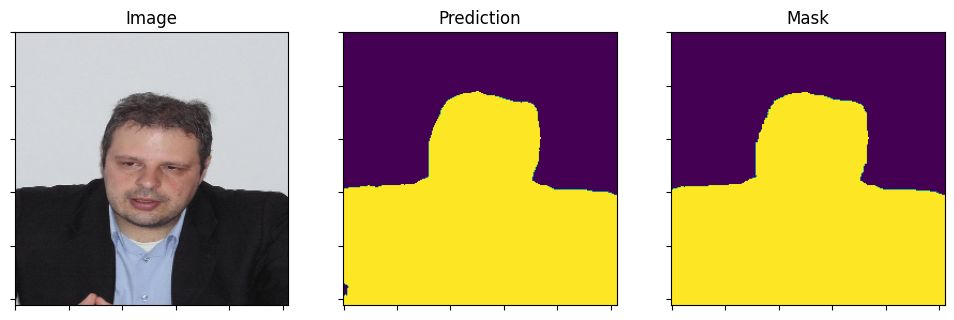

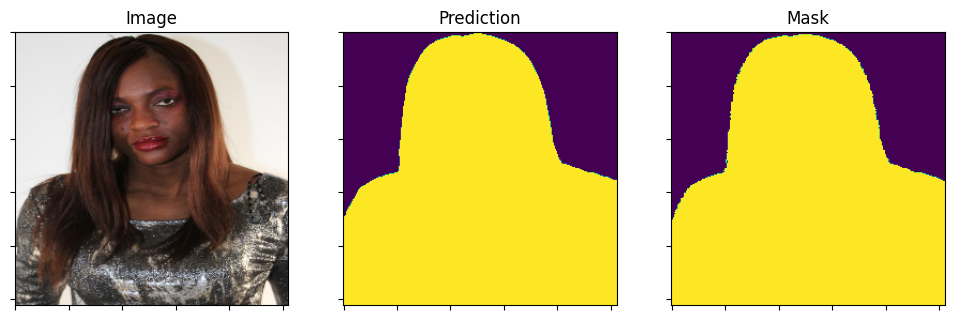

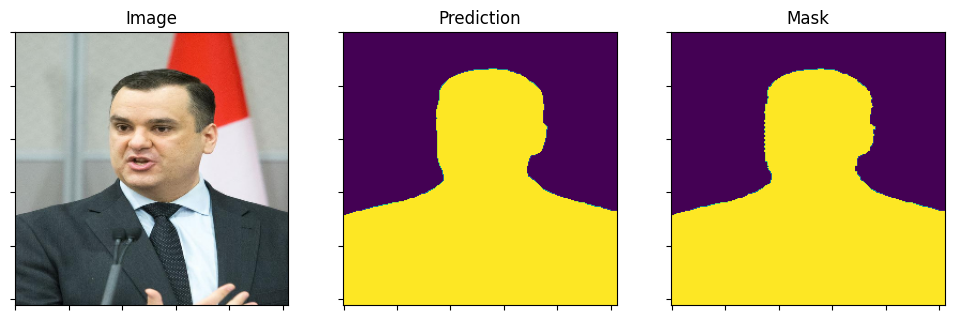

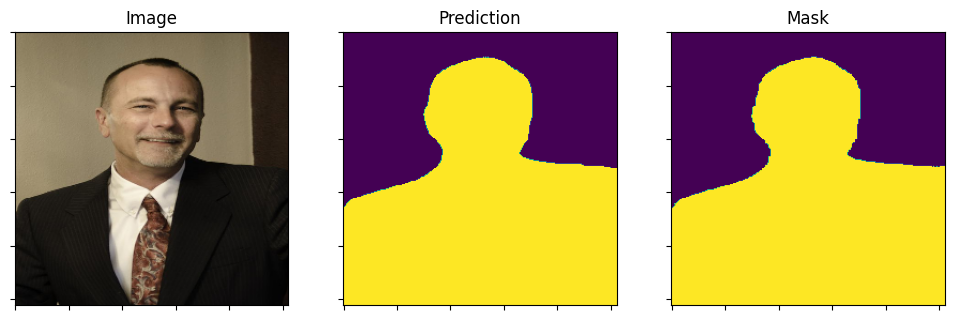

In [31]:
visualizeTopNBestFold(kfold_unet.models, test_dataset, 4)

## Выводы

Таким образом, KFold Unet показал наилучшее качество в IoU Score на тестовой выборке 0.989. При обучении на тренировочном датасете без аугментации качество достигло 0.96, а аугментация подняла его до 0.97. Экспериментально показано, что уменьшение downsample'ов сильно влияет на качество (очевидно). 